### Кластеризация клиентов онлайн-магазина. Выявление клиентов, находящихся в оттоке и предоттоке

##### 1. Импорт библиотек

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import gc
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, OPTICS, Birch
from sklearn import metrics
import concurrent
import time
import numpy as np
from IPython.display import clear_output
import matplotlib

C:\Users\lazar\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


##### 2. Чтение датасета. Знакомство с данными

In [2]:
df = pd.read_csv(r'./clustering_dataset.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.shape)
df.head(3)

(2247574, 15)


,actual_id,period_end,num,revenue_lastyear,quantity_lastyear,orders_lastyear,orders_refund,ratio_not_dh,ratio_online,ratio_refund,avg_ratio_purchase,quantity_1st_period,unigenders,recency,aov
0,12013601421,2021-02-19,2,17920.0,4,1,0,1.0,1.0,0.0,0.8,4.0,1,123,17920.0
1,12013601421,2021-04-19,3,17920.0,4,1,0,1.0,1.0,0.0,0.8,4.0,1,182,17920.0
2,12013601421,2021-06-19,4,17920.0,4,1,0,1.0,1.0,0.0,0.8,4.0,1,243,17920.0


##### Описание датасета:

`quantity_lastyear` --- Количество выкупленных единиц товаров за 1 год от даты окончания i-ого периода
<br>
<br>
`orders_lastyear` --- Количество выкупленных заказов за 1 год от даты окончания i-ого периода
<br>
<br>
`orders_refund` --- Количество выкупленных заказов, по которым был возврат после получения за 1 год от даты окончания i-ого периода
<br>
<br>
`ratio_not_dh` --- Отношение выкупа по стоимости от суммарной базовой стоимости выкупленных товаров за 1 год от даты окончания i-ого периода
<br>
<br>
`ratio_online` --- Доля заказов, оформленных онлайн, от общего числа оформленных заказов за 1 год от даты окончания i-ого периода
<br>
<br>
`ratio_refund` --- Доля заказов, по которым был возврат, от общего числа выкупленных заказов за 1 год от даты окончания i-ого периода
<br>
<br>
`avg_ratio_purchase` --- Среднее отношение за 1 год от даты окончания i-ого периода числа выкупленных товарных позиций к числу оформленных по онлайн-заказам, доставленным к пункту выдачи
<br>
<br>
`quantity_1st_period` --- Количество выкупленных единиц товара за 1-ый период жизни пользователя
<br>
<br>
`unigenders` --- Количество уникальных гендерных характеристик принадлежности товарных позиций по оформленным заказам за все время жизни пользователя от даты окончания i-ого периода
<br>
<br>
`recency` --- Количество дней от даты последнего выкупленного заказа до даты окончания i-ого периода
<br>
<br>
`aov` --- Средний чек по выкупленным заказам за 1 год от даты окончания i-ого периода
<br>
<br>
`num` -- Месяц жизни клиента

In [ ]:
# Приведение столбцов к необходимым форматам
df['period_end'] = pd.to_datetime(df['period_end'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247574 entries, 0 to 2247573
Data columns (total 15 columns):
 #   Column               Dtype         
---  ------               -----         
 0   actual_id            int64         
 1   period_end           datetime64[ns]
 2   num                  int64         
 3   revenue_lastyear     float64       
 4   quantity_lastyear    int64         
 5   orders_lastyear      int64         
 6   orders_refund        int64         
 7   ratio_not_dh         float64       
 8   ratio_online         float64       
 9   ratio_refund         float64       
 10  avg_ratio_purchase   float64       
 11  quantity_1st_period  float64       
 12  unigenders           int64         
 13  recency              int64         
 14  aov                  float64       
dtypes: datetime64[ns](1), float64(7), int64(7)
memory usage: 257.2 MB


##### 3. Разведочный анализ:

In [ ]:
# Пропусков не наблюдаю
df.isnull().sum()

actual_id              0
period_end             0
num                    0
revenue_lastyear       0
quantity_lastyear      0
orders_lastyear        0
orders_refund          0
ratio_not_dh           0
ratio_online           0
ratio_refund           0
avg_ratio_purchase     0
quantity_1st_period    0
unigenders             0
recency                0
aov                    0
dtype: int64

In [ ]:
# Отсортируем данные по дате окончания периода
df.sort_values(by='period_end', inplace=True)

In [ ]:
# Судя по всему, столбцы quantity_lastyear, orders_lastyear, quantity_1st_period и orders_refund содержат выбросы
df.describe().T

,count,mean,std,min,25%,50%,75%,max
actual_id,2247574.0,2.743856e+13,9.871432e+15,638.0,7.912462e+10,7.919928e+10,7.950406e+10,4.415340e+18
num,2247574.0,6.089290e+00,3.164263e+00,2.0,3.000000e+00,6.000000e+00,8.000000e+00,1.400000e+01
revenue_lastyear,2247574.0,3.099290e+04,6.037296e+04,0.0,3.980000e+03,1.398000e+04,3.492000e+04,7.365842e+06
quantity_lastyear,2247574.0,3.321365e+00,6.016230e+00,0.0,1.000000e+00,2.000000e+00,4.000000e+00,6.290000e+02
orders_lastyear,2247574.0,2.006601e+00,3.069162e+00,0.0,1.000000e+00,1.000000e+00,2.000000e+00,2.810000e+02
orders_refund,2247574.0,1.232200e-01,6.905141e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.260000e+02
ratio_not_dh,2247574.0,7.761333e-01,4.014436e-01,0.0,8.341633e-01,1.000000e+00,1.000000e+00,1.000000e+00
ratio_online,2247574.0,2.389008e-01,3.838896e-01,0.0,0.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00
ratio_refund,2247574.0,3.704832e-02,1.554406e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
avg_ratio_purchase,2247574.0,9.649268e-01,1.458924e-01,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
# # Анализируя взаимные графики, вижу, что между некоторыми признаками есть корреляция
# sns.pairplot(df)
# plt.show()

<ipython-input-9-e1455bf3a29c>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".1f")


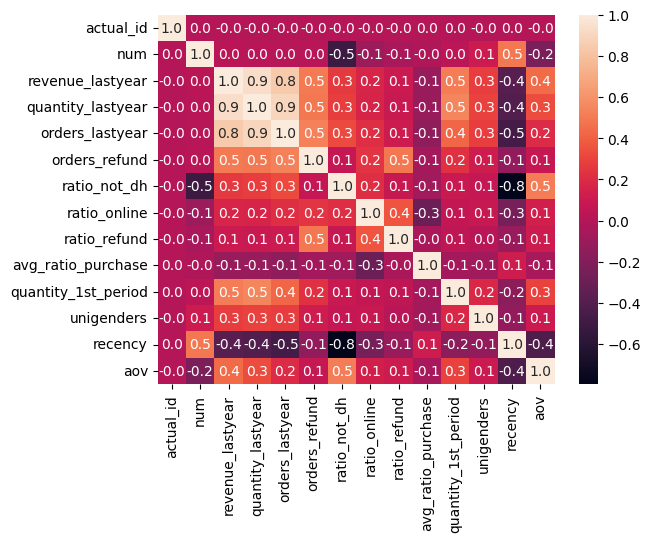

In [ ]:
#Вижу сильно коррелирующие между собой строки:
# revenue_lastyear - quantity_lastyear - orders_lastyear
# ratio_not_dh - recency
# Скорее всего, далее объеденим коррелирующие признаки в один

sns.heatmap(df.corr(), annot=True, fmt=".1f")
plt.show()

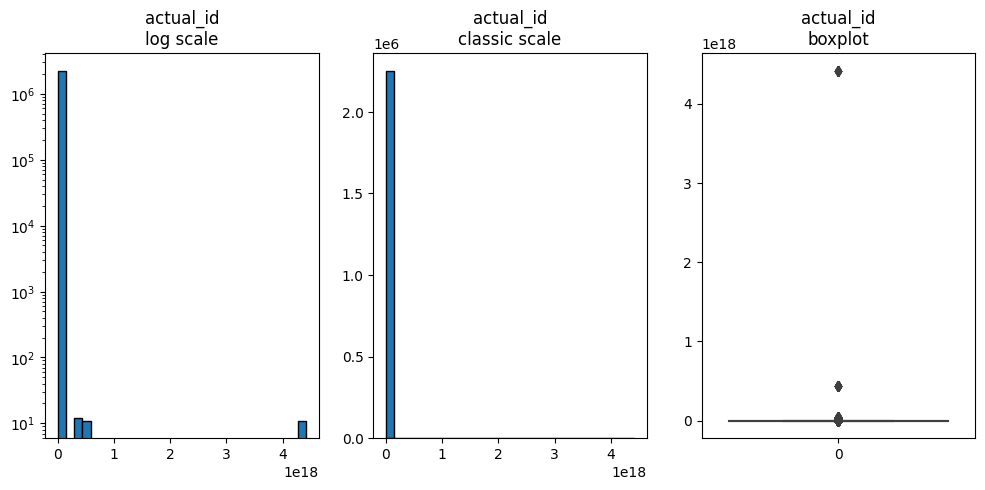

skipped column period_end


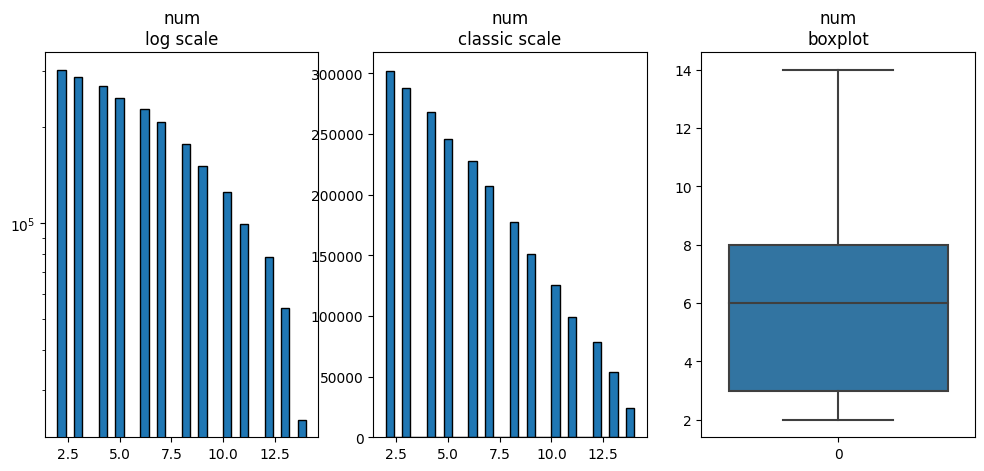

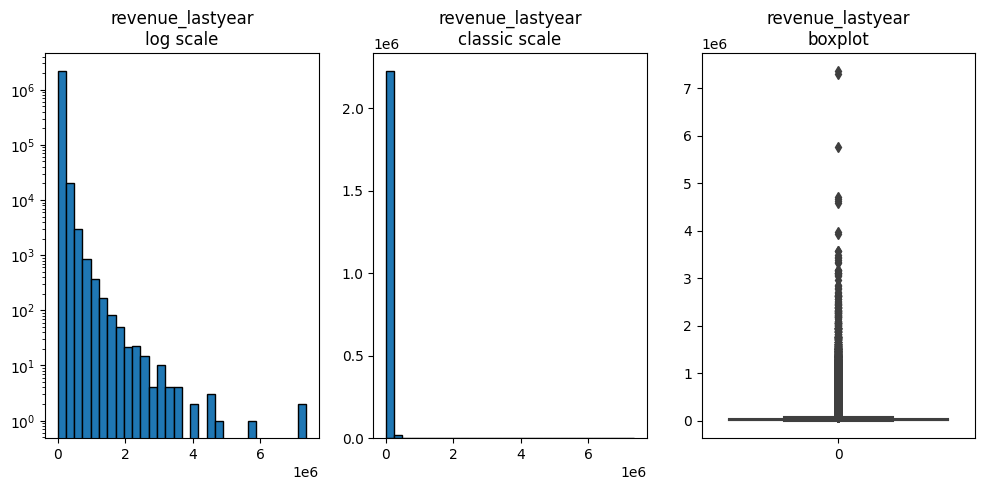

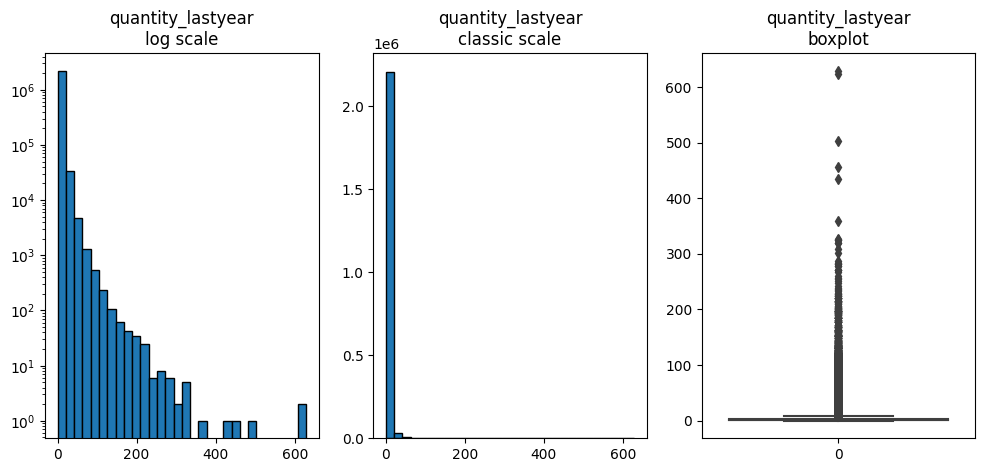

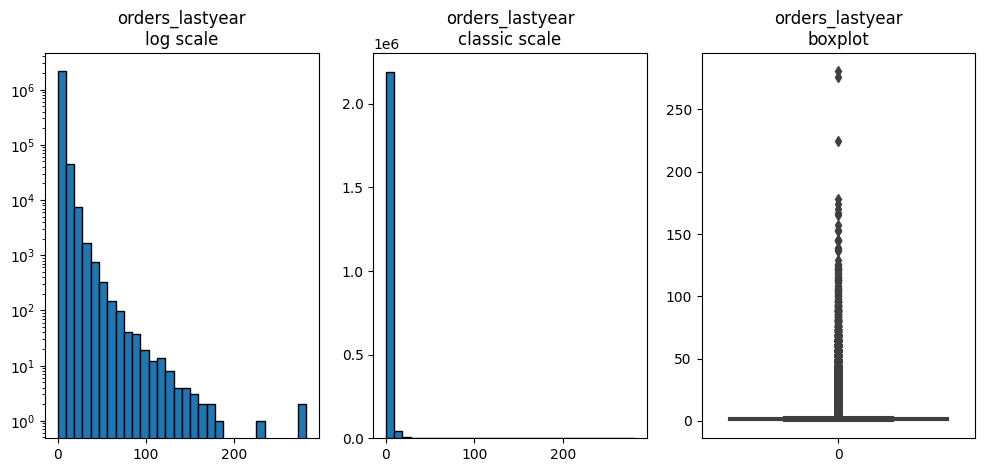

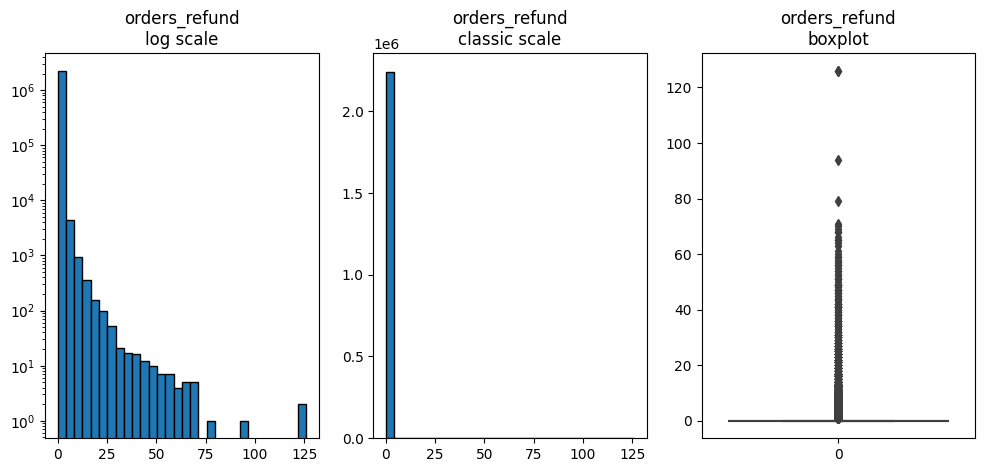

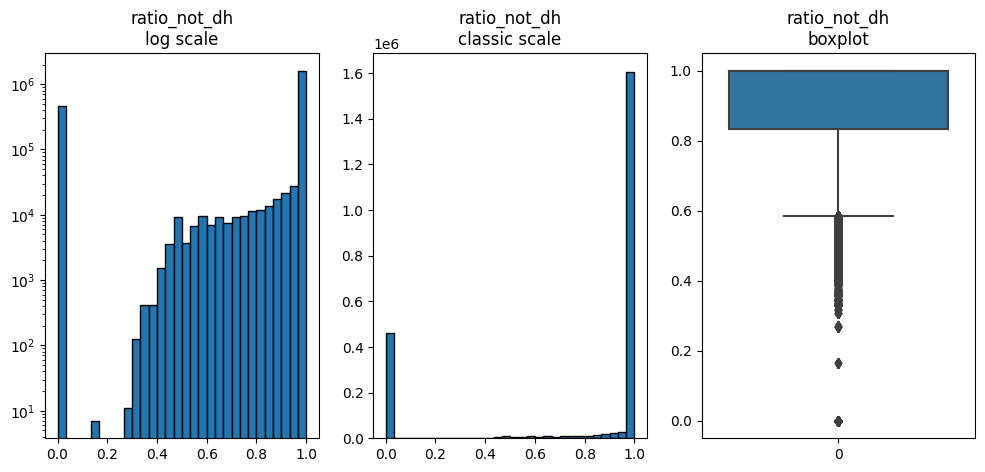

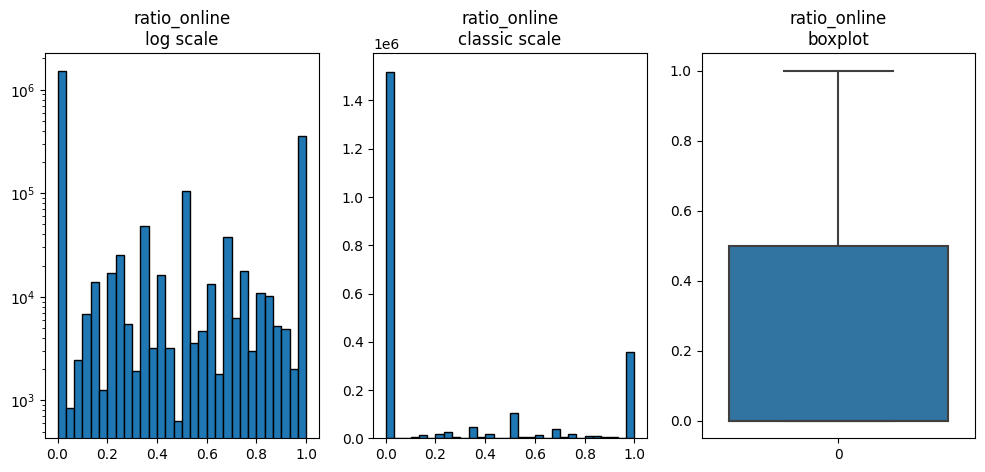

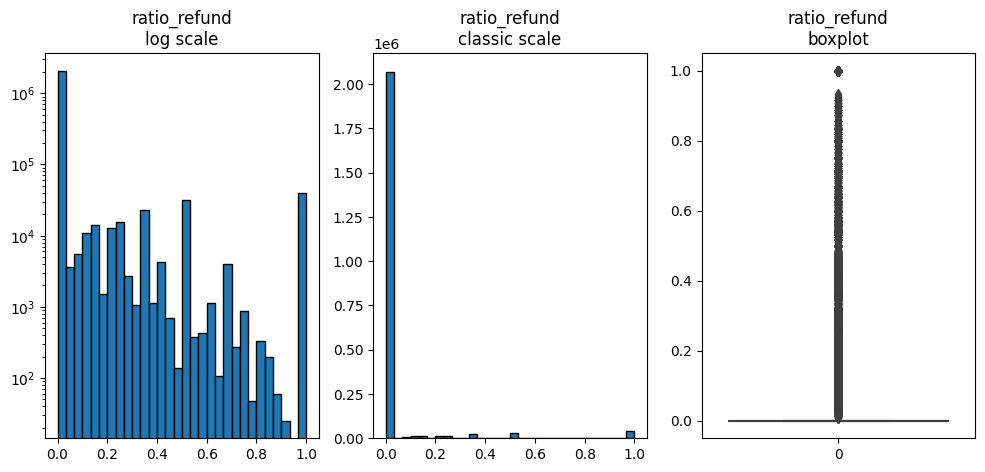

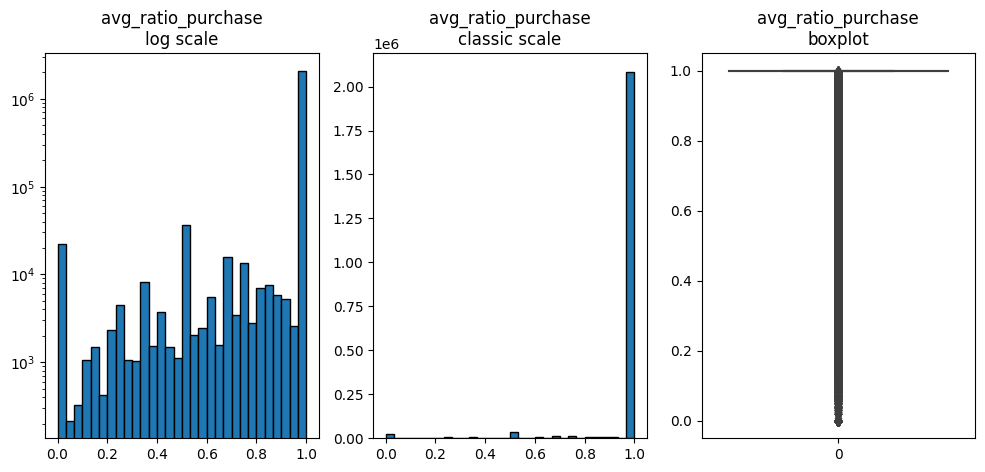

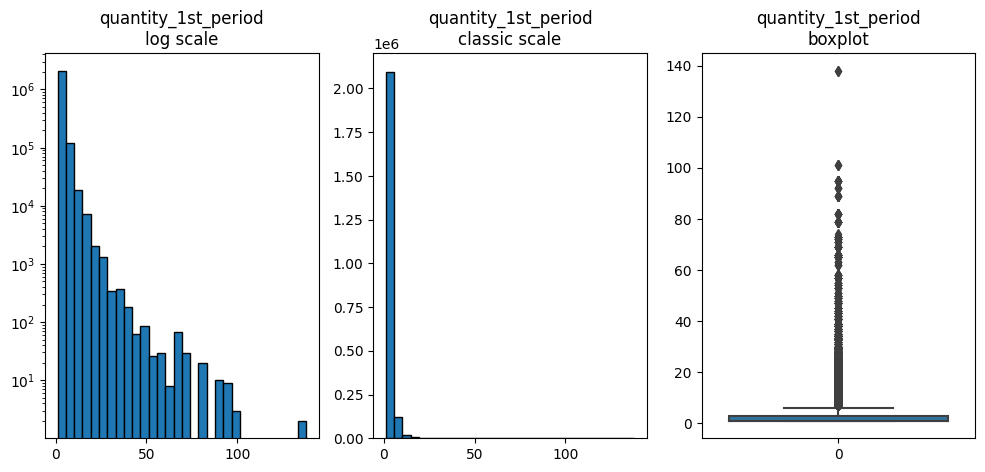

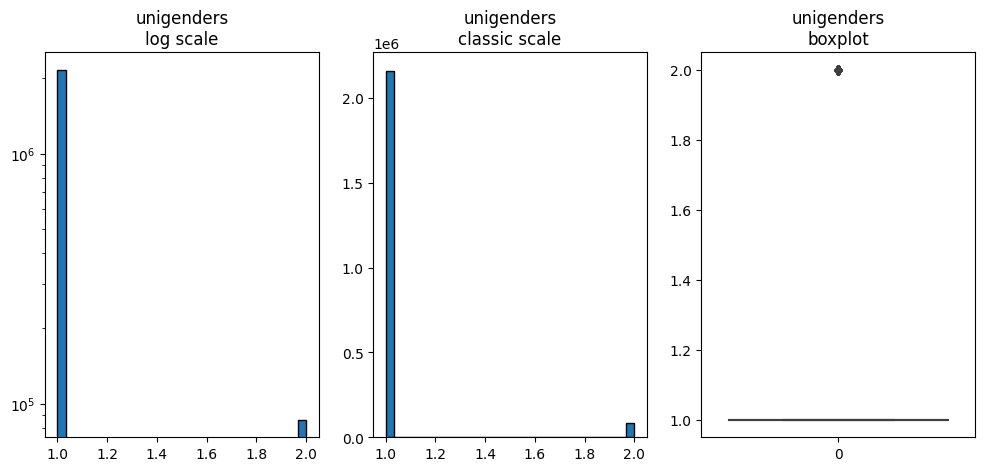

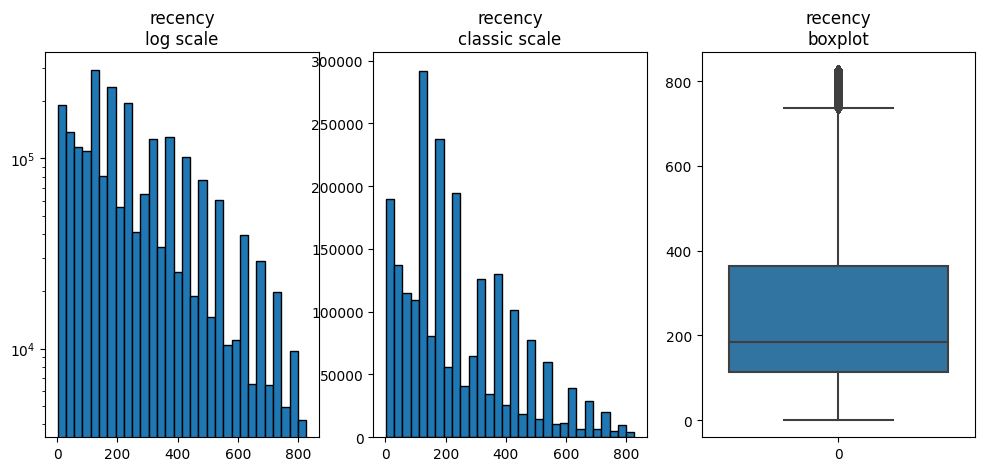

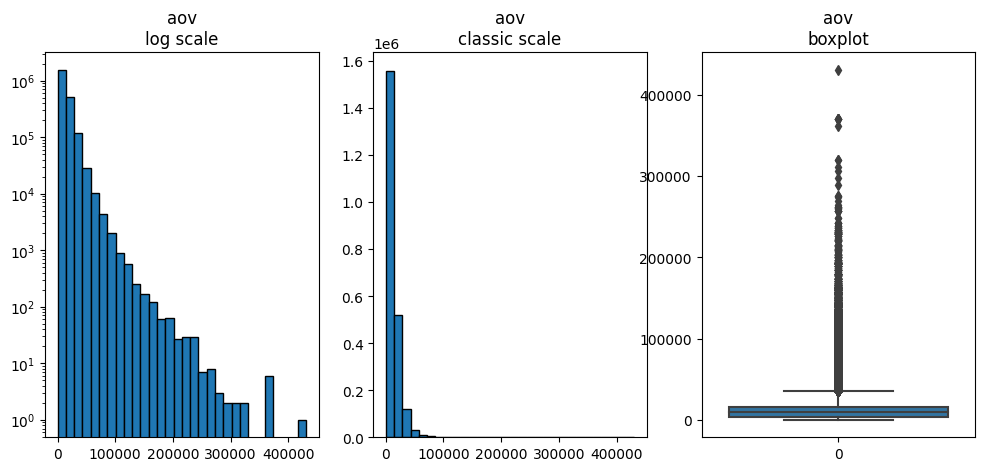

In [ ]:
# Посмотрим на распределение признаков более детально:
for column in df.columns:
    try:
        fig, axes = plt.subplots(ncols=3)
        ax1, ax2, ax3 = axes.flatten()
        ax1.hist(df[column], bins=30, ec='black')
        ax2.hist(df[column], bins=30, ec='black')
        sns.boxplot(df[column], ax=ax3)
        ax1.set_yscale('log')
        ax1.set_title(f'{column}\nlog scale')
        ax2.set_title(f'{column}\nclassic scale')
        ax3.set_title(f'{column}\nboxplot')
        plt.gcf().set_size_inches(12, 5)
        plt.show()
    except:
        print(f'skipped column {column}')
        plt.close()

###### Почти для всех графиков определить зону выбросов достаточно сложно. Однако если не ограничить данные, при масштабировании данных, большая часть данных сильно сожмется. С другой стороны, с сильно обрезать данные тоже нельзя.
Считаю, что необходимо удалить следующие данные:<br>
revenue_lastyear - выбросы:>2e6<br>
quantity_lastyear - выбросы: > 200<br>
orders_lastyear - выбросы: > 100<br>
(все три столбца сильно коррелируют между собой, поэтому скорее всего в выбросах находятся одни и те же данные)

orders_refund - выбросы: > 50<br>
quantity_1st_period - выбросы: > 100<br>
aov - выбросы: > 200000<br>

In [ ]:
print('В целом, удаляем не так много выбросов. Как вариант, можно попробовать удалить больше - посмотреть, как себя будет чувствовать модель:')
print(f"Количество выбросов revenue_lastyear: {df[df['revenue_lastyear'] > 2e6].shape[0]}")
print(f"Количество выбросов quantity_lastyear: {df[df['quantity_lastyear'] > 200].shape[0]}")
print(f"Количество выбросов orders_lastyear: {df[df['orders_lastyear'] > 100].shape[0]}")
print(f"Количество выбросов orders_refund: {df[df['orders_refund'] > 50].shape[0]}")
print(f"Количество выбросов quantity_1st_period: {df[df['quantity_1st_period'] > 100].shape[0]}")
print(f"Количество выбросов aov: {df[df['aov'] > 200000].shape[0]}")

В целом, удаляем не так много выбросов. Как вариант, можно попробовать удалить больше - посмотреть, как себя будет чувствовать модель:
Количество выбросов revenue_lastyear: 88
Количество выбросов quantity_lastyear: 67
Количество выбросов orders_lastyear: 58
Количество выбросов orders_refund: 32
Количество выбросов quantity_1st_period: 5
Количество выбросов aov: 121


##### Общий вывод по разведочному анализу:
1. Удаляем обозначенные ранее выбросы по 6 признакам (revenue_lastyear, quantity_lastyear, orders_lastyear, orders_refund, quantity_1st_period, aov);
2. Объеденяем коррелирующие признаки: (revenue_lastyear - quantity_lastyear - orders_lastyear), (ratio_not_dh - recency). Если хватит оперативной памяти - через SVD, если нет - через PCA
3. Пропусков не наблюдаю.

In [ ]:
# Удаляем выбросы
counter = df.shape[0]
df = df[df['revenue_lastyear'] < 2e6].copy()
df = df[df['quantity_lastyear'] < 200].copy()
df = df[df['orders_lastyear'] < 100].copy()
df = df[df['orders_refund'] < 50].copy()
df = df[df['quantity_1st_period'] < 100].copy()
df = df[df['aov'] < 200000].copy()
print(f'Удалено {counter-df.shape[0]} наблюдений')

Удалено 268 наблюдений


In [ ]:
# Создание резервной копии для дальнейшей оценки проведенной кластеризации
df_for_check = df.copy()

##### 4. Масштабирование данных
Т.к. решаем задачу кластеризации, реализуем масштабирование через Min-Max scaler

In [ ]:
# Без данной операции при конкатинации появляются новые строки
df.reset_index(drop=True, inplace=True)

scaler = MinMaxScaler()
colums_without_scaling = df[['actual_id', 'period_end', 'num']].copy()
df.drop(columns=['actual_id', 'period_end', 'num'], inplace=True)
colum_names = df.columns
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=colum_names)
df = pd.concat([colums_without_scaling, df], axis=1)
df.head(3)

,actual_id,period_end,num,revenue_lastyear,quantity_lastyear,orders_lastyear,orders_refund,ratio_not_dh,ratio_online,ratio_refund,avg_ratio_purchase,quantity_1st_period,unigenders,recency,aov
0,79644207708,2021-01-01,2,0.004495,0.005051,0.010101,0.0,1.0,1.000000,0.0,1.0,0.000000,0.0,0.146489,0.044909
1,79272268330,2021-01-01,2,0.035561,0.020202,0.030303,0.0,1.0,0.333333,0.0,1.0,0.021277,0.0,0.007264,0.118427
2,79216416495,2021-01-01,2,0.023435,0.010101,0.020202,0.0,1.0,0.500000,0.0,1.0,0.010638,0.0,0.116223,0.117066


##### 5. Feature Engineering
В данном разделе объединим коррелирующие признаки в один, при необходимости сгенерируем новые

In [ ]:
pca1 = PCA(n_components=1)
df['feature_1'] = pca1.fit_transform(df[['revenue_lastyear','quantity_lastyear', 'orders_lastyear']])

In [ ]:
pca2 = PCA(n_components=1)
df['feature_2'] = pca2.fit_transform(df[['ratio_not_dh', 'recency']])

<ipython-input-17-84e5c5a71fdd>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".1f")


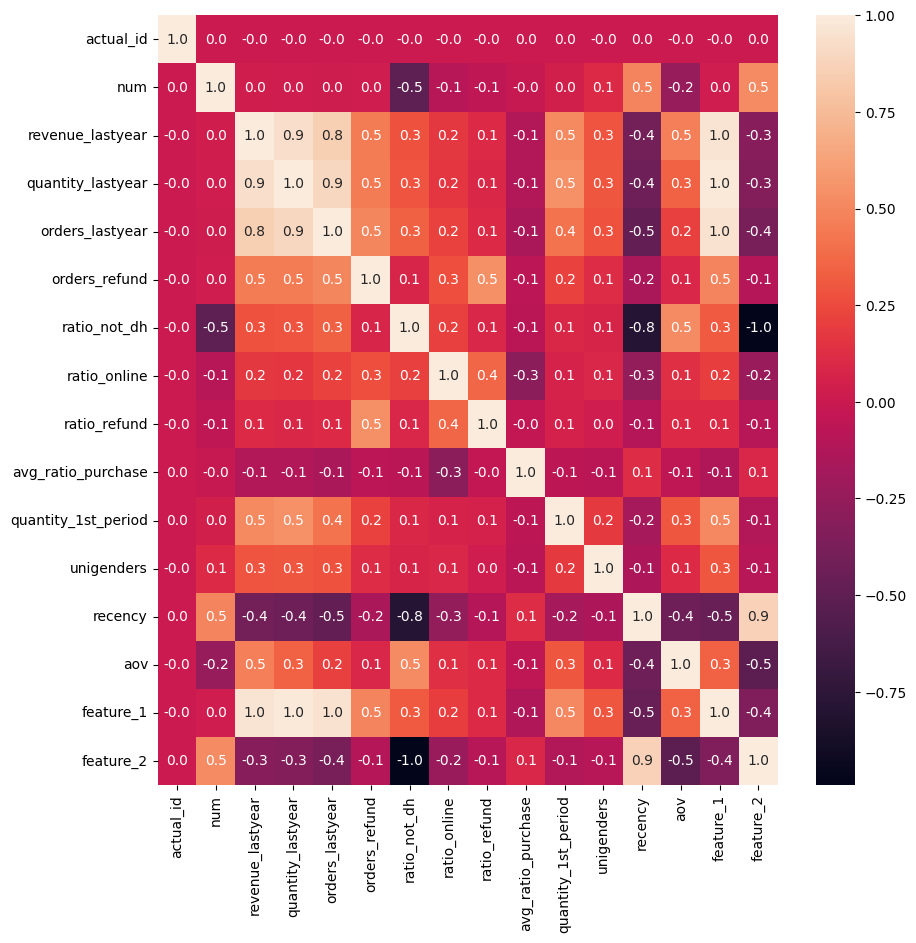

In [ ]:
sns.heatmap(df.corr(), annot=True, fmt=".1f")
plt.gcf().set_size_inches(10,10)
plt.show()

In [ ]:
# Удаляем объединенные признаки:
df.drop(columns=['revenue_lastyear','quantity_lastyear', 'orders_lastyear', 'ratio_not_dh', 'recency'], inplace=True)

In [ ]:
# В итоге кластеризуем клиентов по следующим признакам:
x = df[['orders_refund', 'ratio_online',
       'ratio_refund', 'avg_ratio_purchase', 'quantity_1st_period',
       'unigenders', 'aov', 'feature_1', 'feature_2']].copy()

##### Дополнительно можно сгенерировать новые признаки, если модель будет показывать не самое лучшее качество

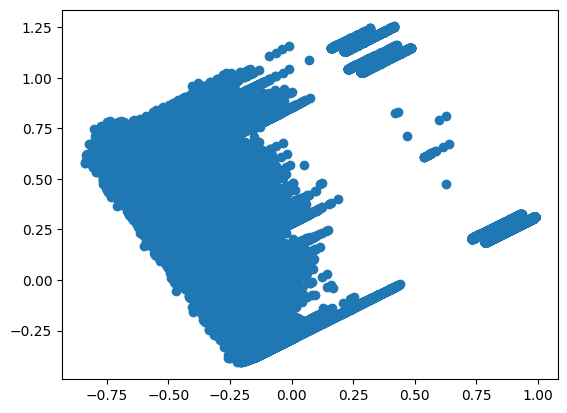

In [ ]:
# Провизуализируем наш датасет:
pca_for_image = PCA(n_components=2)
x_for_image = pca_for_image.fit_transform(x)
plt.scatter(x_for_image[:, 0], x_for_image[:, 1])
plt.show()

##### 6. Нормализация данных

In [ ]:
# Нормализуем данные при помощи логарифма по основанию 10:
# Вместо использования логарифмирования также можно использовать метод Бокса-Кокса
for column in x.columns:
    x[column] = np.log10(x[column]-x[column].min()+0.001)

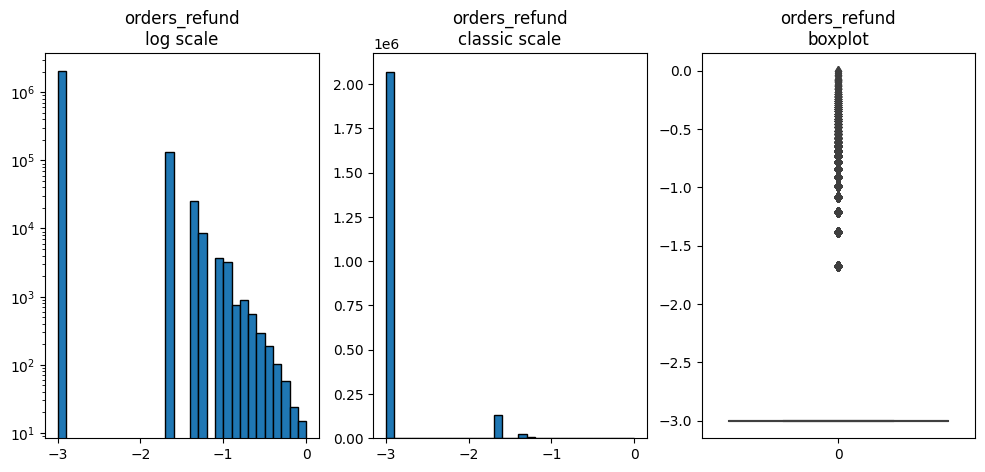

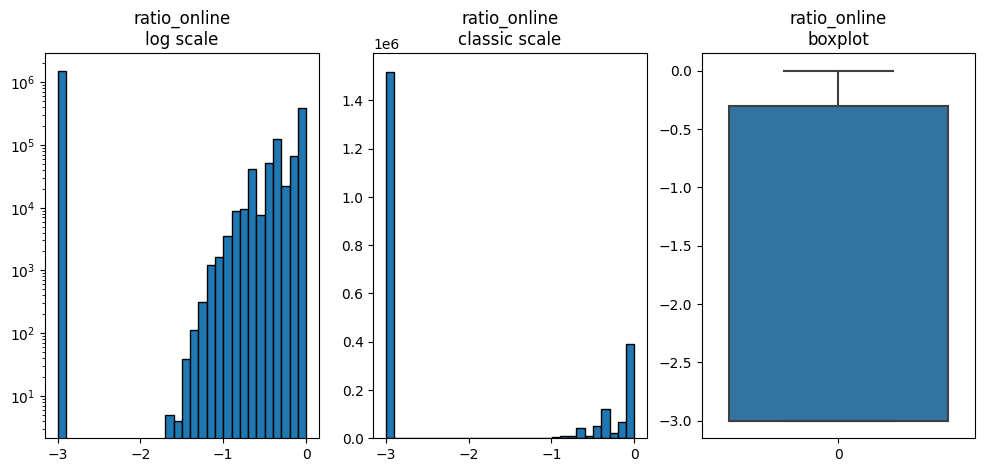

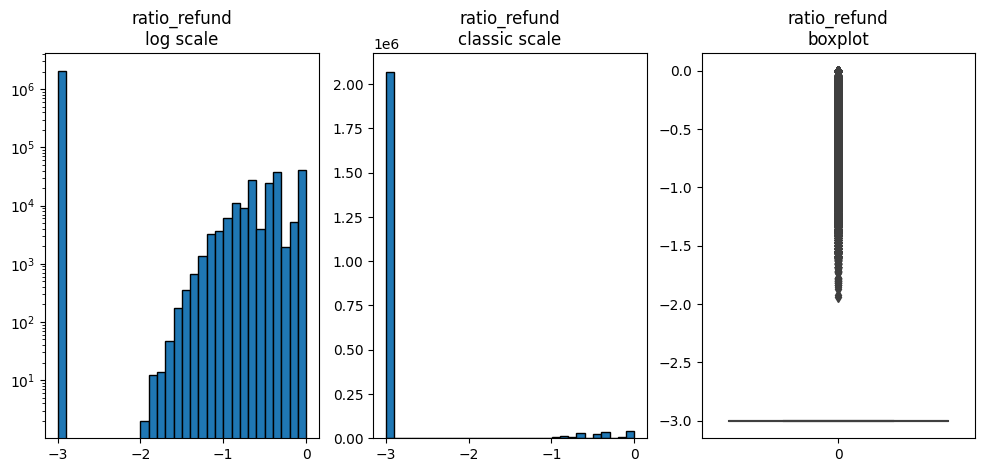

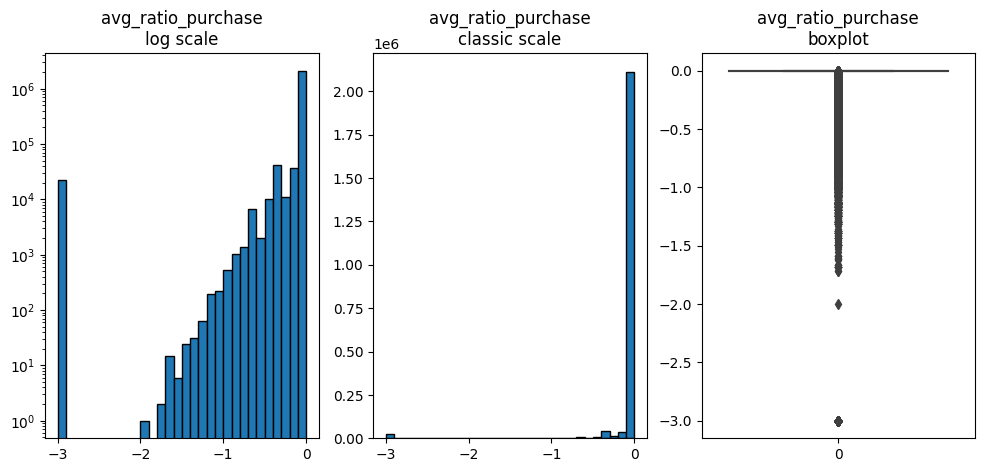

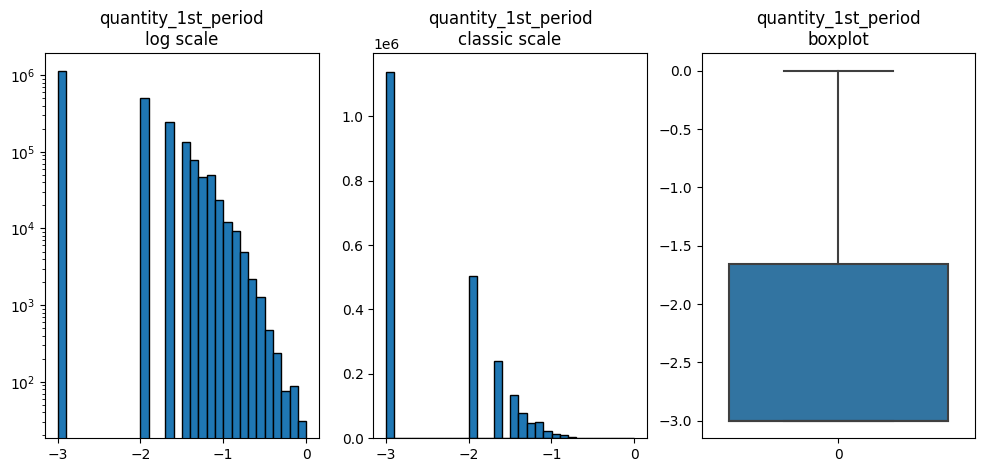

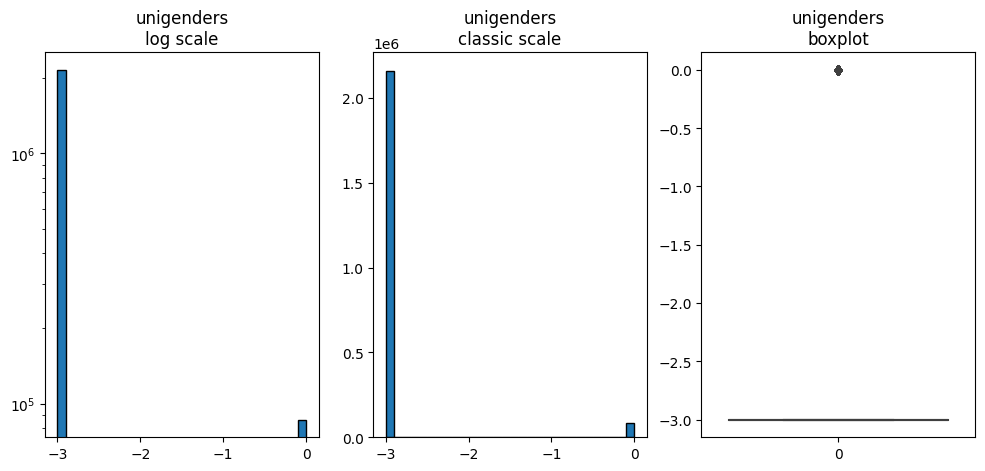

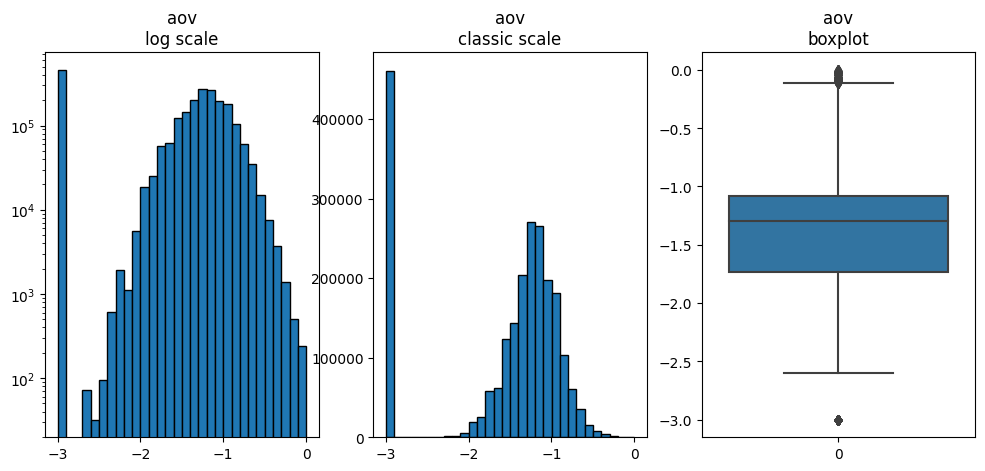

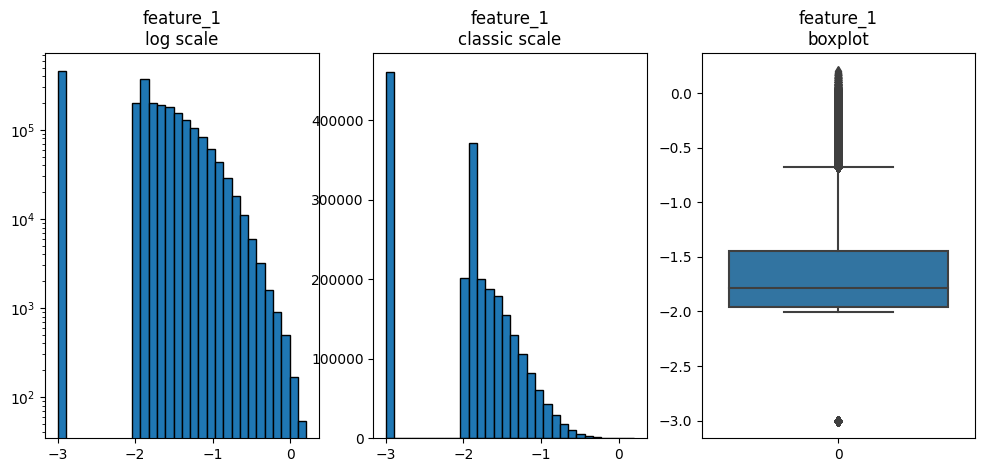

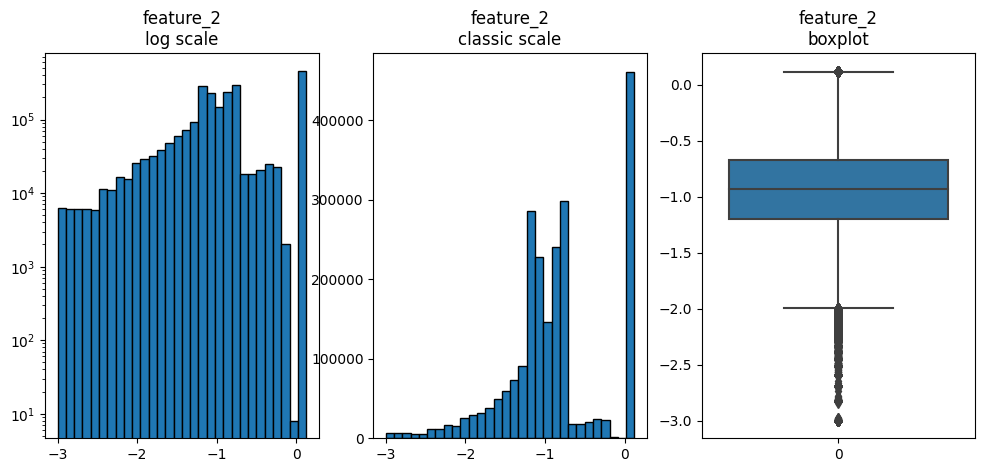

In [ ]:
# Посмотрим на распределение признаков более детально:
for column in x.columns:
    try:
        fig, axes = plt.subplots(ncols=3)
        ax1, ax2, ax3 = axes.flatten()
        ax1.hist(x[column], bins=30, ec='black')
        ax2.hist(x[column], bins=30, ec='black')
        sns.boxplot(x[column], ax=ax3)
        ax1.set_yscale('log')
        ax1.set_title(f'{column}\nlog scale')
        ax2.set_title(f'{column}\nclassic scale')
        ax3.set_title(f'{column}\nboxplot')
        plt.gcf().set_size_inches(12, 5)
        plt.show()
    except:
        print(f'skipped column {column}')
        plt.close()

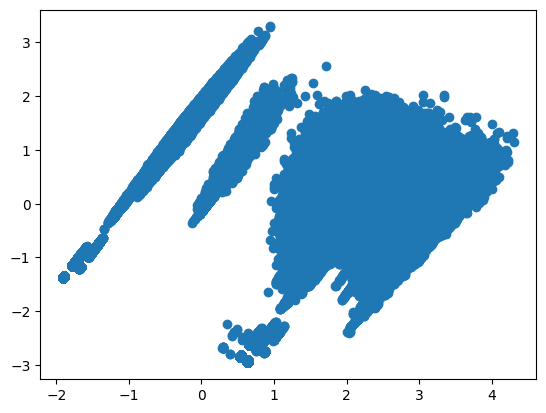

In [ ]:
# Провизуализируем наш датасет после нормализации:
pca_for_image = PCA(n_components=2)
x_for_image = pca_for_image.fit_transform(x)
plt.scatter(x_for_image[:, 0], x_for_image[:, 1])
plt.show()

##### 7. Кластеризация клиентов
Оценку кластеризации будем проводить по индексу Калински-Харабаса и индексу Дэвиса-Боулдина

In [ ]:
# Для запуска параллельной обработки оценим количество ядер на ПК
import multiprocessing

cores = multiprocessing.cpu_count() # Count the number of cores at a computer
cores

2

In [ ]:
# Запуск параллельной обработки
start = time.time()

def process_row(n_clusters):
    global x
    global start

    print(f'now creating {n_clusters}-clusters model. Time passed: {round(time.time() - start, 2)} seconds')

    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    y = kmeans.fit_predict(x)


    calinski_harabasz = metrics.calinski_harabasz_score(x, y)
    davies_bouldin = metrics.davies_bouldin_score(x, y)
    #silhouette = metrics.silhouette_score(x, y, metric='euclidean')

    row = {
      'n_clusters': n_clusters,
      #'silhouette_score': silhouette,
      'calinski_harabasz_score': calinski_harabasz,
      'davies_bouldin_score': davies_bouldin,
      'method': 'kmeans'
    }

    return row

with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    results = executor.map(process_row, [el for el in range(2,13)])

metrics_clusters = pd.DataFrame.from_records(list(results))

now creating 2-clusters model. Time passed: 0.0 seconds
now creating 3-clusters model. Time passed: 0.01 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


now creating 4-clusters model. Time passed: 14.26 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


now creating 5-clusters model. Time passed: 17.32 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


now creating 6-clusters model. Time passed: 33.77 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


now creating 7-clusters model. Time passed: 46.2 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


now creating 8-clusters model. Time passed: 66.77 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


now creating 9-clusters model. Time passed: 91.52 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


now creating 10-clusters model. Time passed: 119.93 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


now creating 11-clusters model. Time passed: 145.66 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


now creating 12-clusters model. Time passed: 193.74 seconds


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
metrics_clusters

,n_clusters,calinski_harabasz_score,davies_bouldin_score,method
0,2,1.685909e+06,1.023647,kmeans
1,3,1.825423e+06,0.810442,kmeans
2,4,2.005651e+06,0.779780,kmeans
3,5,1.929758e+06,0.784612,kmeans
4,6,1.826955e+06,0.938376,kmeans
5,7,2.020249e+06,0.842233,kmeans
6,8,1.974046e+06,0.780237,kmeans
7,9,1.960829e+06,0.787936,kmeans
8,10,1.866410e+06,0.868296,kmeans
9,11,1.972252e+06,0.821759,kmeans


In [ ]:
# Не хватает оперативной памяти для выполнения кода ниже для проведения спектральной кластеризации
# start = time.time()

# def process_row(n_clusters):
#   global x
#   global start

#   print(f'now creating {n_clusters}-clusters model. Time passed: {round(time.time() - start, 2)} seconds')

#   spectr = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize', random_state=0)
#   y = spectr.fit_predict(x)

#   calinski_harabasz = metrics.calinski_harabasz_score(x, y)
#   davies_bouldin = metrics.davies_bouldin_score(x, y)
#   #silhouette = metrics.silhouette_score(x, y, metric='euclidean')

#   row = {
#       'n_clusters': n_clusters,
#       #'silhouette_score': silhouette,
#       'calinski_harabasz_score': calinski_harabasz,
#       'davies_bouldin_score': davies_bouldin,
#       'method': 'spectralclustering'
#   }

#   return row

# with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
#   results = executor.map(process_row, [el for el in range(2,10)])

# metrics_clusters_spectre = pd.DataFrame.from_records(list(results))

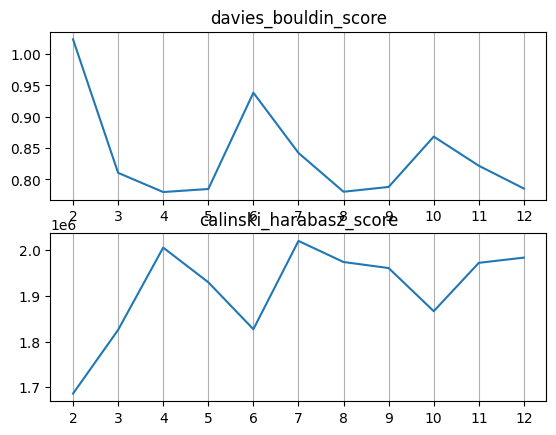

In [ ]:
# Опираясь на полученные индексы, 4 кластера выглядят как оптимальное количество
fig, axes = plt.subplots(nrows=2)
axes[0].plot(metrics_clusters['n_clusters'], metrics_clusters['davies_bouldin_score'])
axes[0].set_xticks([el for el in range(metrics_clusters['n_clusters'].min(), metrics_clusters['n_clusters'].max() + 1)])
axes[0].set_title('davies_bouldin_score')
axes[0].grid(axis='x')

axes[1].plot(metrics_clusters['n_clusters'], metrics_clusters['calinski_harabasz_score'])
axes[1].set_xticks([el for el in range(metrics_clusters['n_clusters'].min(), metrics_clusters['n_clusters'].max() + 1)])
axes[1].set_title('calinski_harabasz_score')
axes[1].grid(axis='x')

plt.show()

In [ ]:
kmeans_final = KMeans(n_clusters=4, random_state=0)
labels = kmeans_final.fit_predict(x)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
unique_labels, counts = np.unique(labels, return_counts=True)
for i, label in enumerate(unique_labels):
    print(f'{label}: {counts[i]}')

0: 1064762
1: 175801
2: 449297
3: 557446


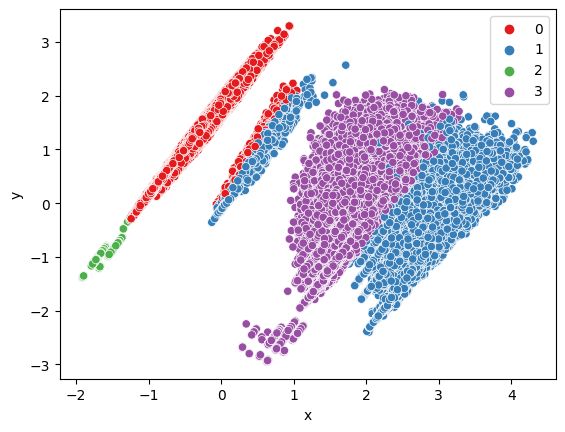

In [ ]:
# Провизуализируем наш датасет:
pca_for_image = PCA(n_components=2)
x_for_image = pca_for_image.fit_transform(x)
x_for_image = pd.DataFrame(x_for_image, columns=['x', 'y'])
sns.scatterplot(data=x_for_image, x='x', y='y', hue=labels, palette='Set1')
plt.show()

In [ ]:
df_for_check.reset_index(drop=True, inplace=True)
df_for_check = pd.concat([df_for_check, pd.DataFrame({'label': labels})], axis=1)
df_for_check.head(3)

,actual_id,period_end,num,revenue_lastyear,quantity_lastyear,orders_lastyear,orders_refund,ratio_not_dh,ratio_online,ratio_refund,avg_ratio_purchase,quantity_1st_period,unigenders,recency,aov,label
0,79644207708,2021-01-01,2,8980.0,1,1,0,1.0,1.000000,0.0,1.0,1.0,1,122,8980.000000,3
1,79272268330,2021-01-01,2,71042.0,4,3,0,1.0,0.333333,0.0,1.0,3.0,1,7,23680.666667,3
2,79216416495,2021-01-01,2,46817.0,2,2,0,1.0,0.500000,0.0,1.0,2.0,1,97,23408.500000,3


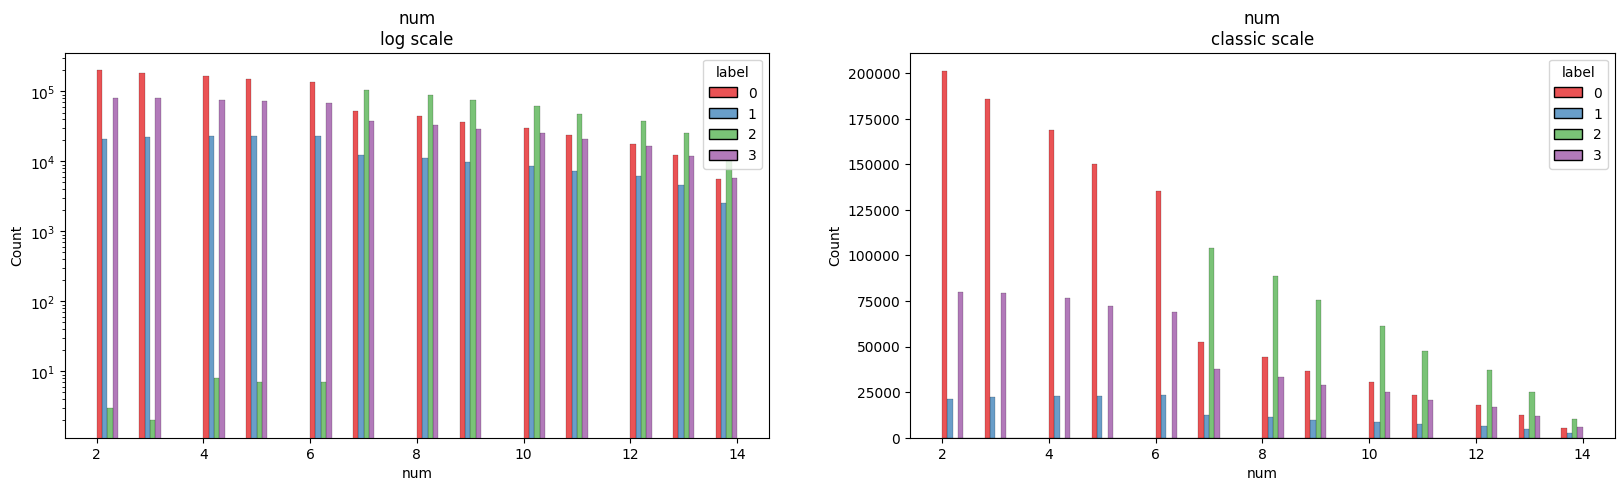

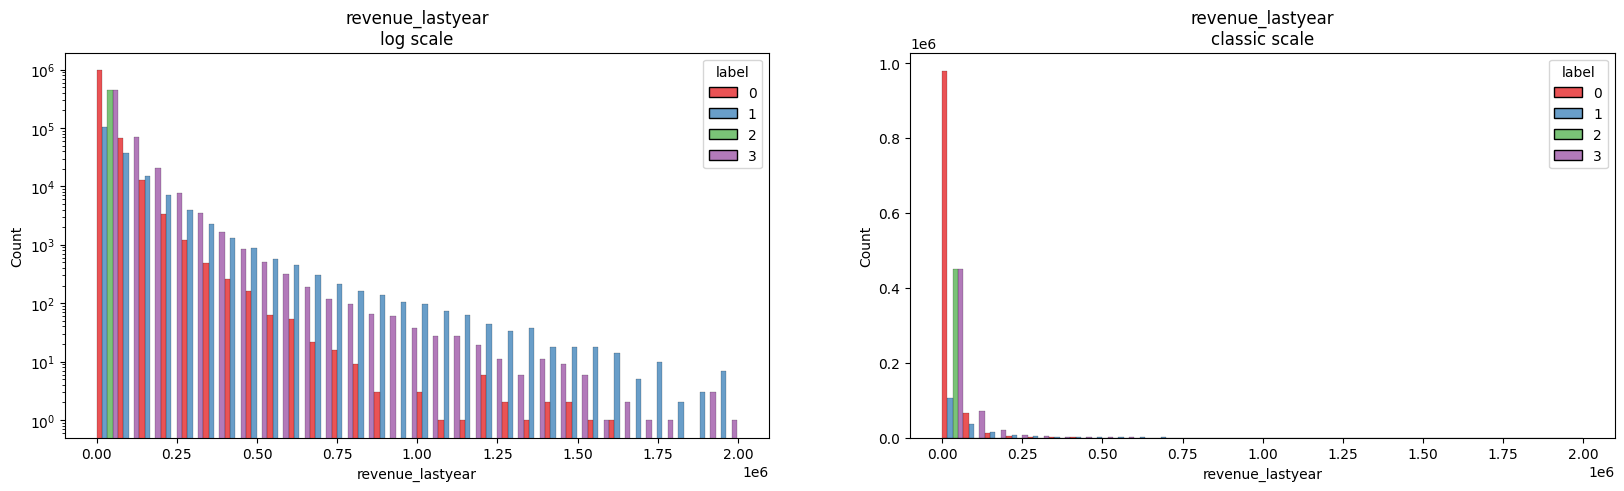

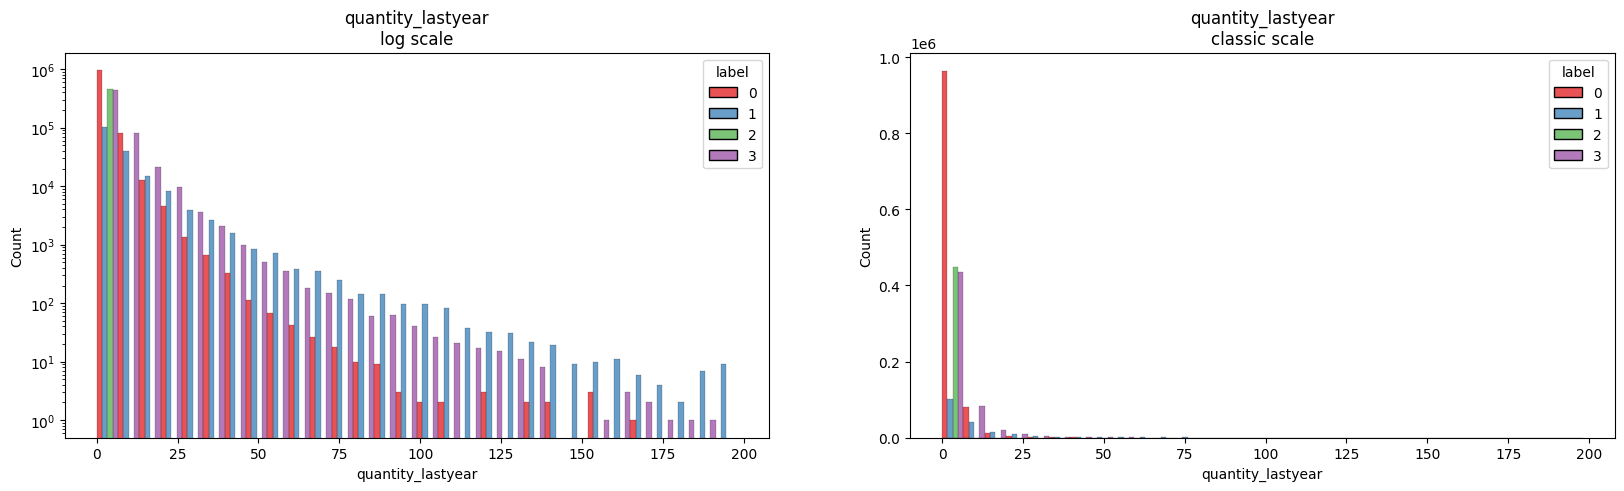

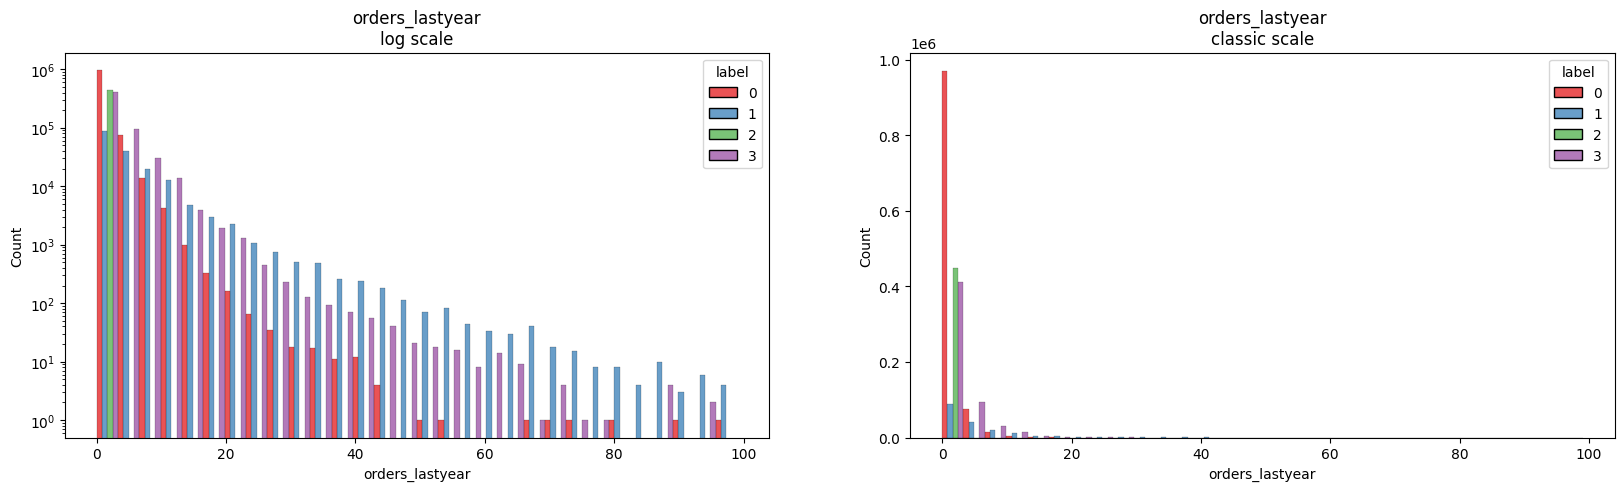

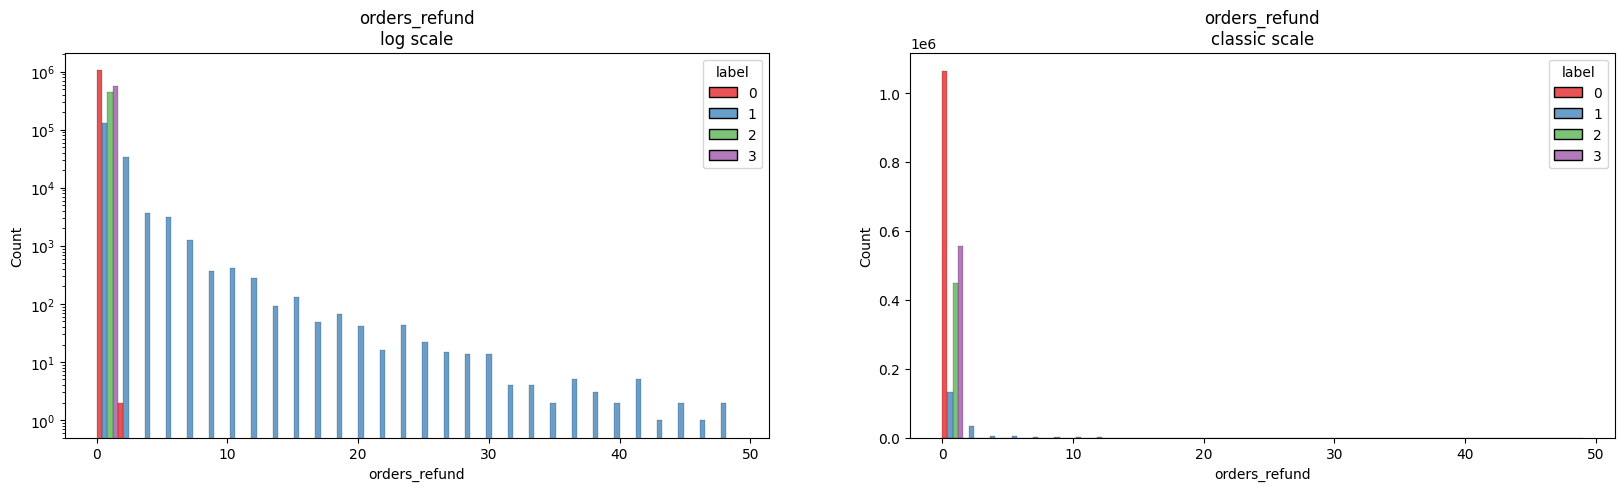

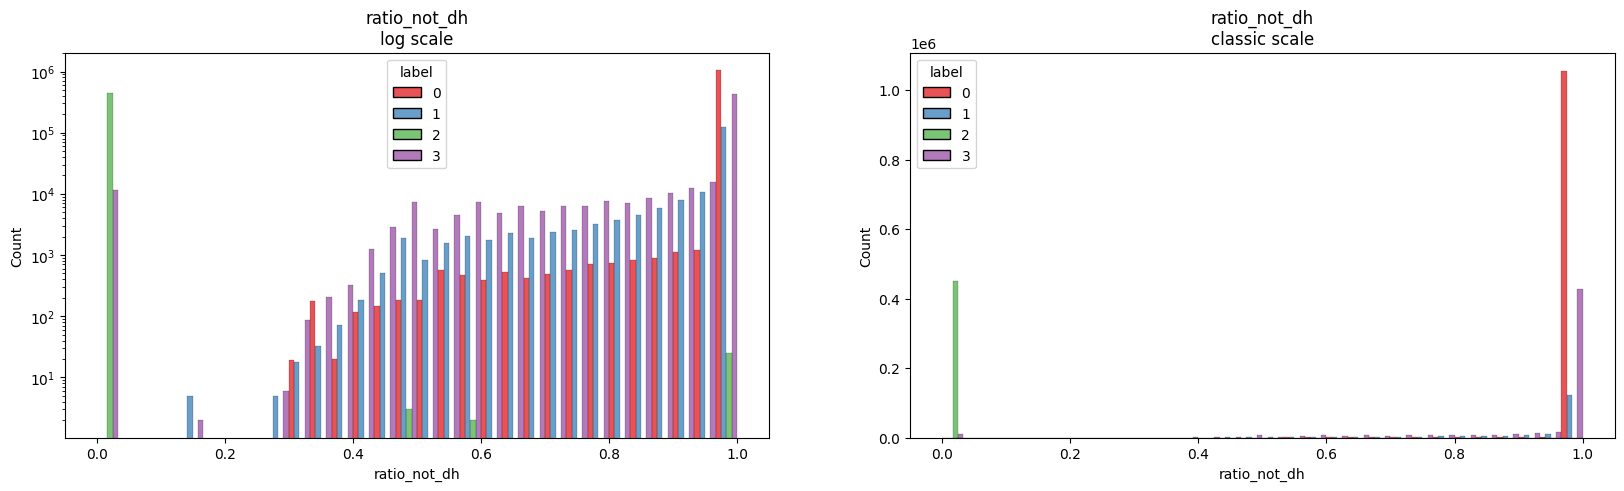

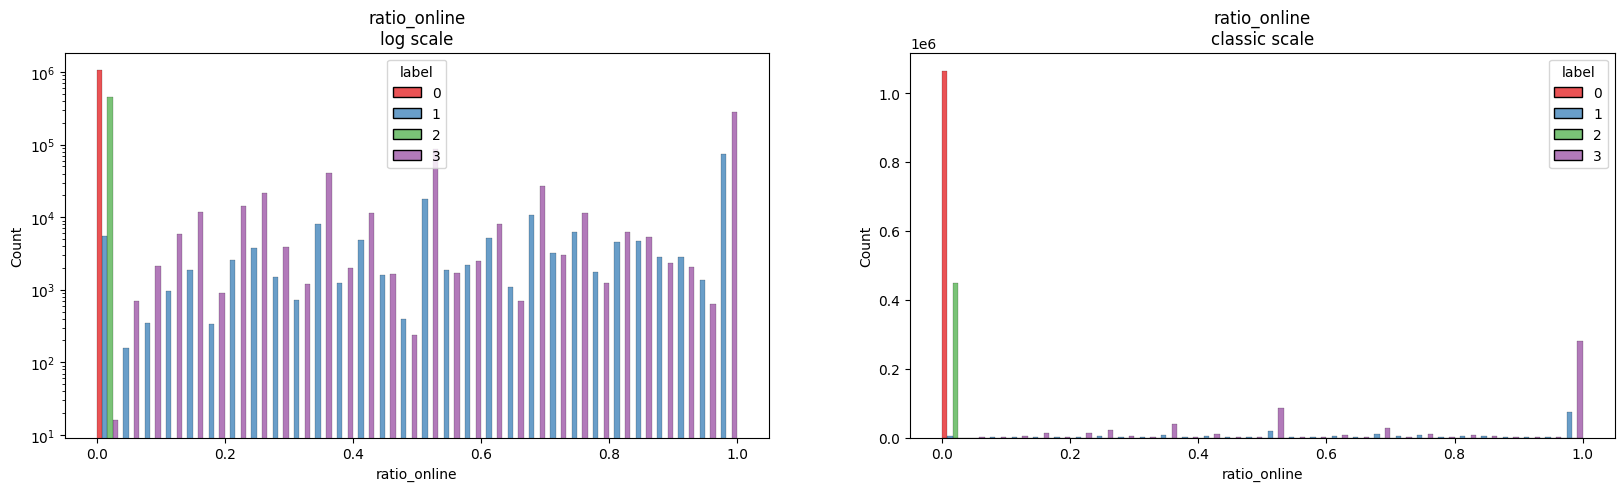

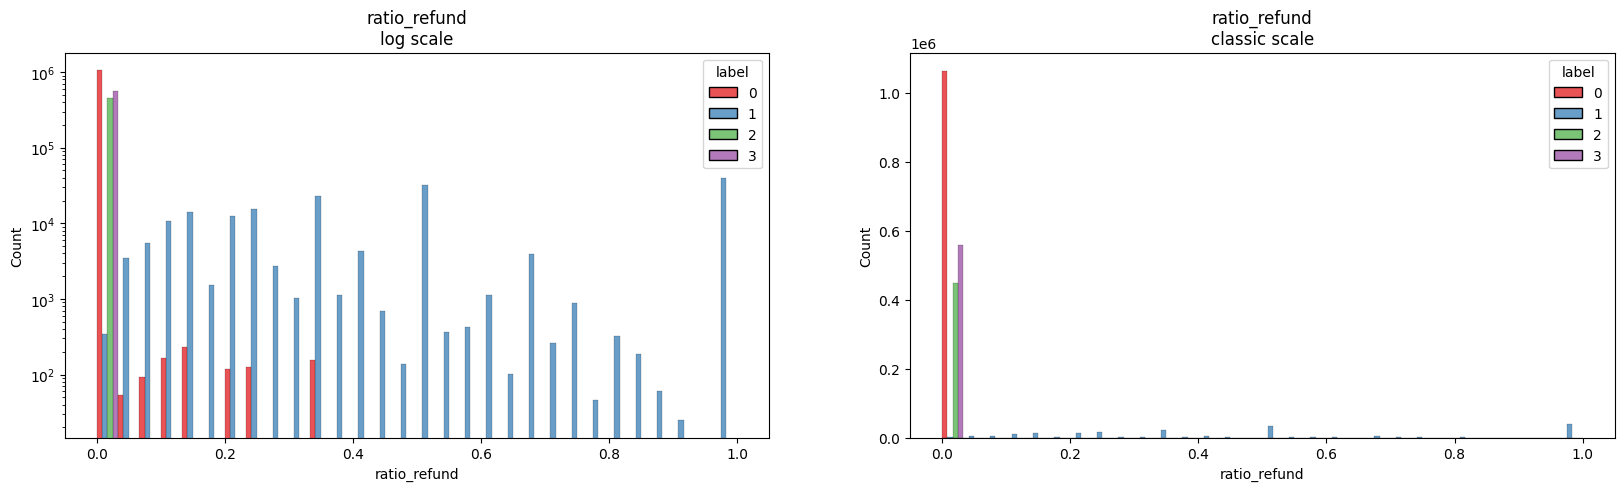

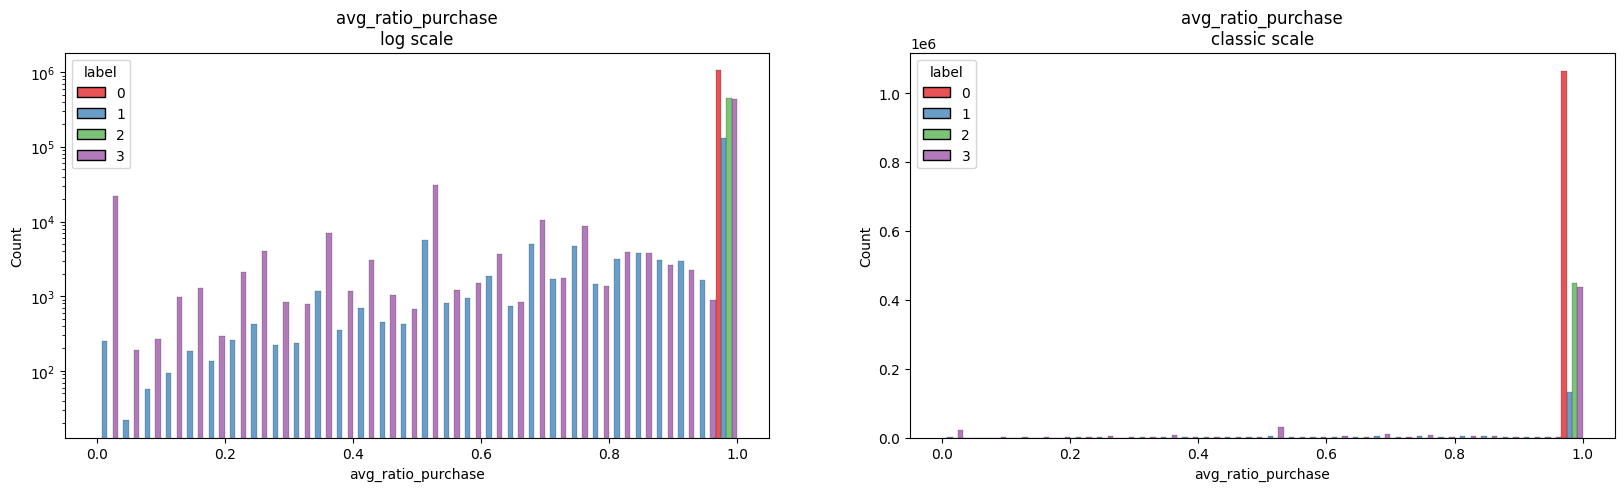

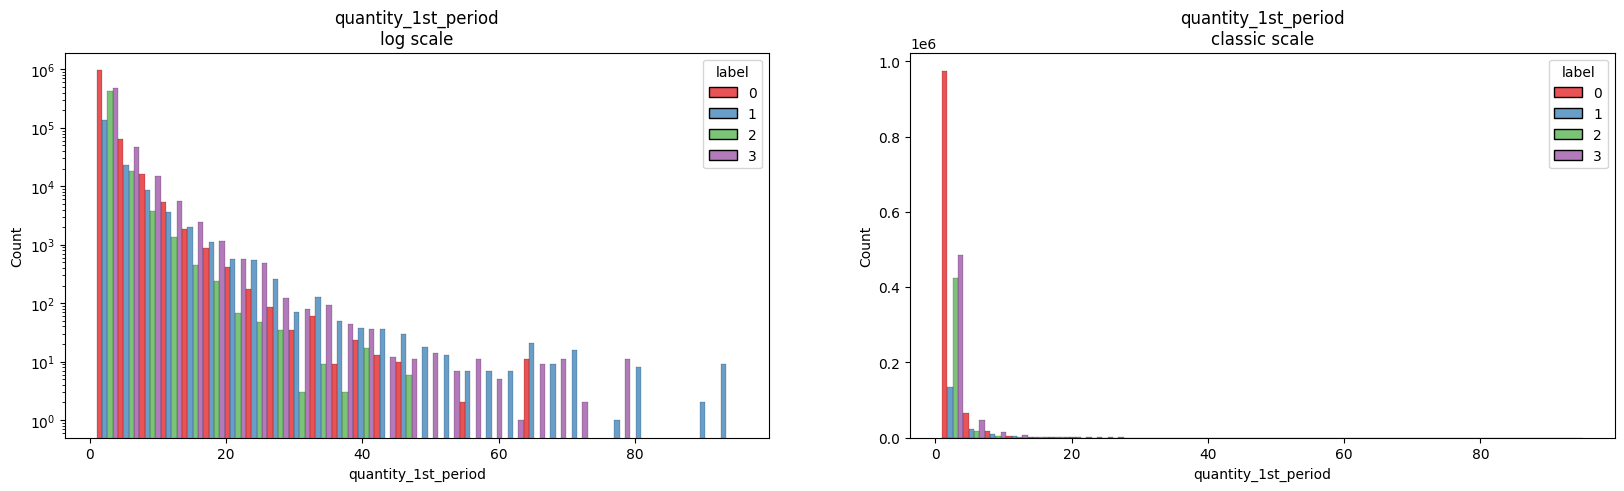

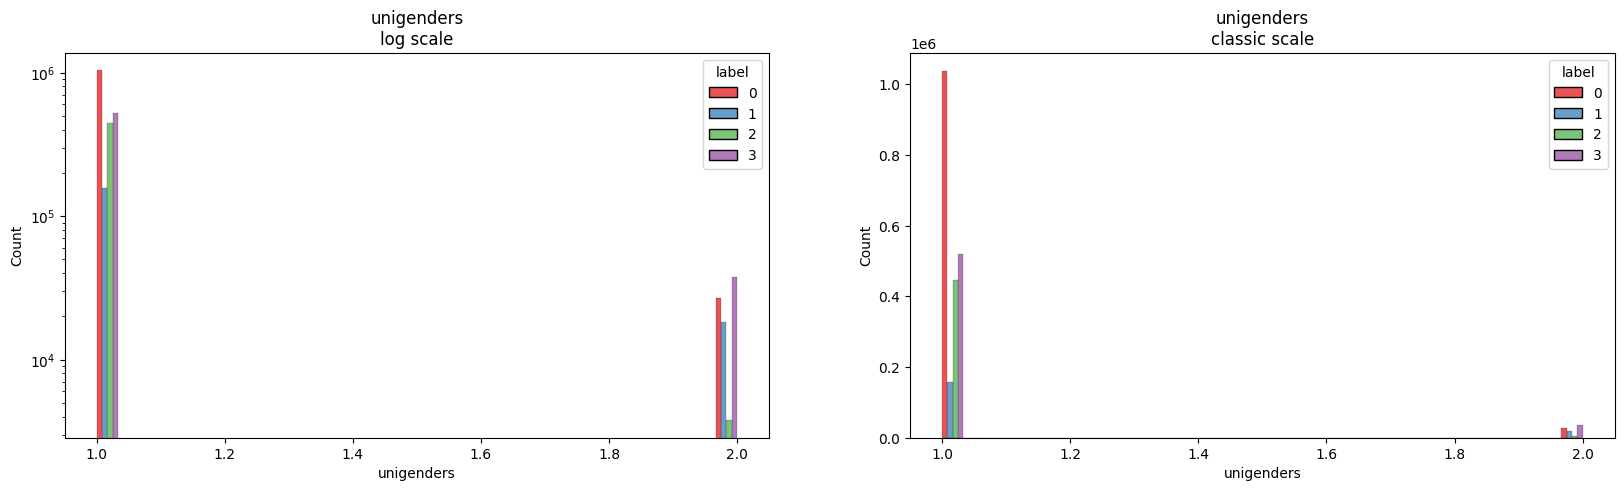

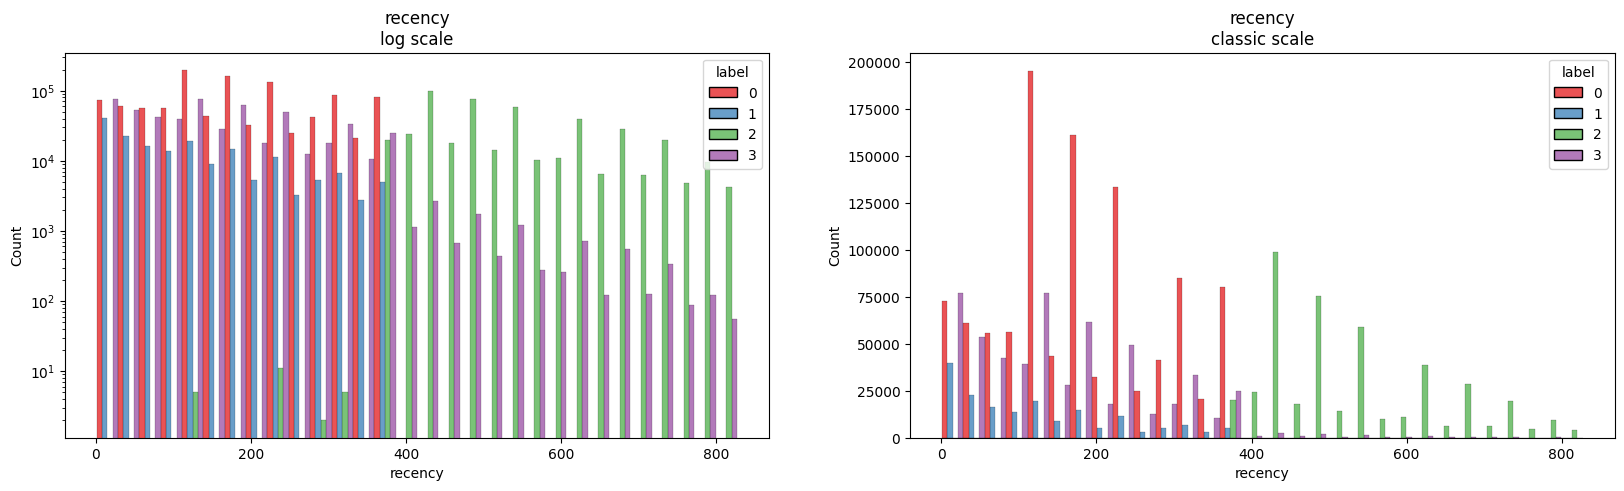

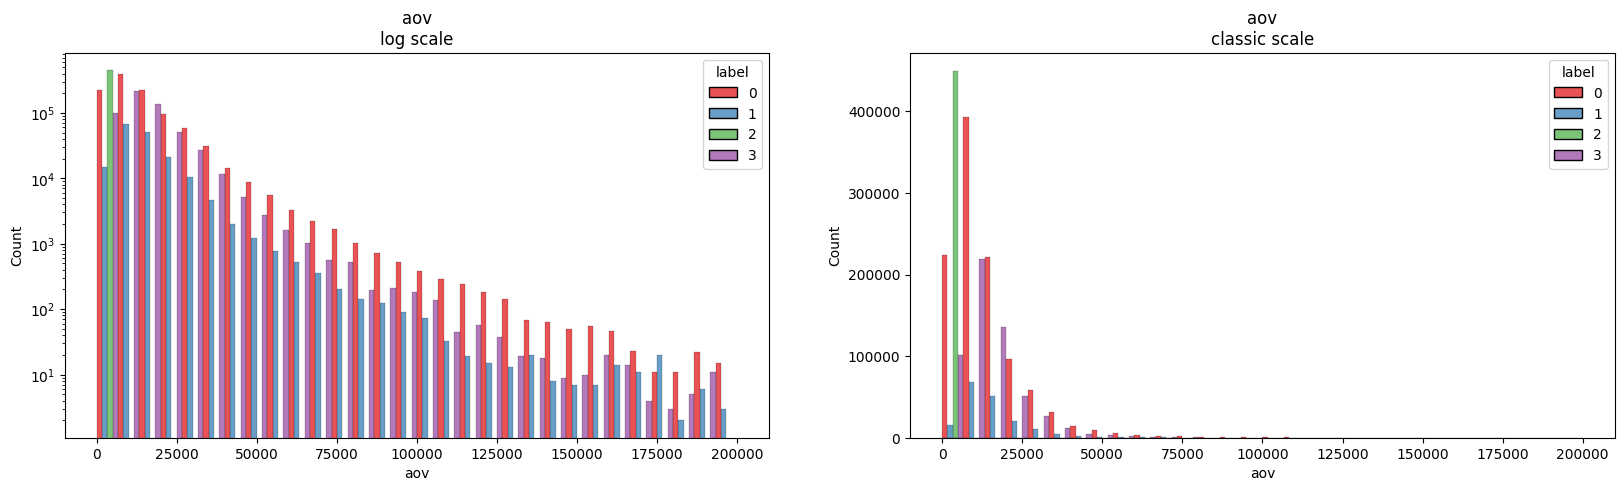

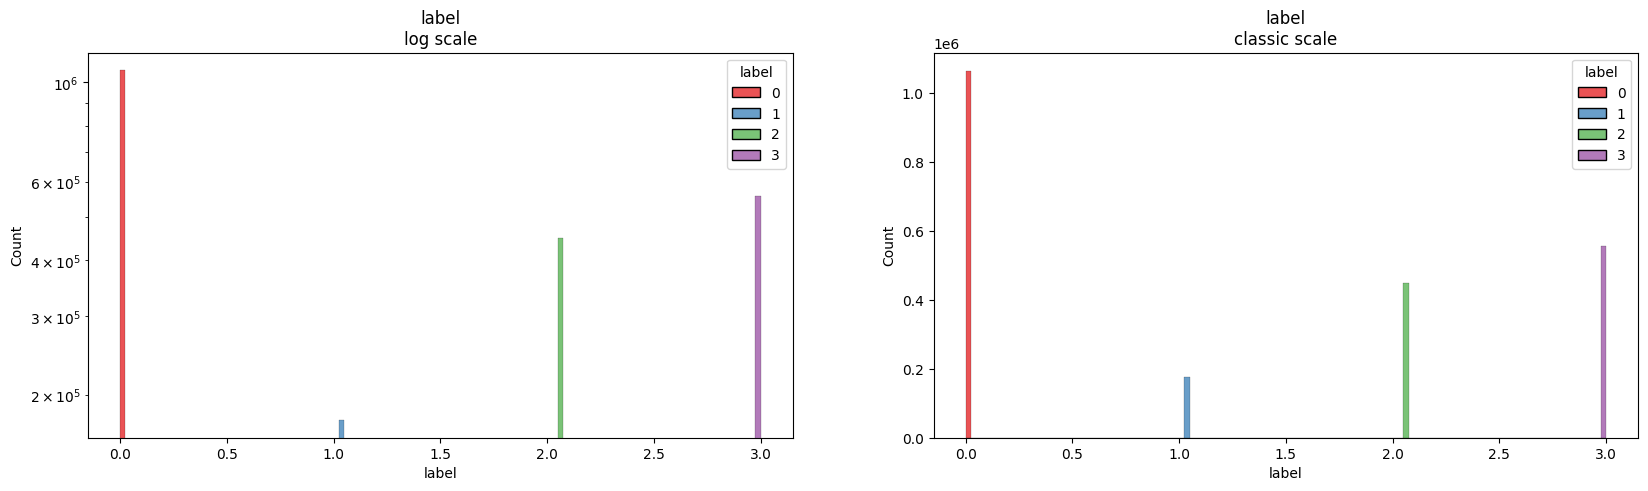

In [ ]:
# Посмотрим на распределение признаков более детально, изучим особеености кластеров:
for column in df_for_check.columns:
    if column in ['actual_id', 'period_end']:
    continue
    fig, axes = plt.subplots(ncols=2)
    ax1, ax2 = axes.flatten()
    sns.histplot(data=df_for_check,x=column, bins=30, ec='black', hue='label', palette='Set1', multiple="dodge", ax=ax1)
    sns.histplot(data=df_for_check,x=column, bins=30, ec='black', hue='label', palette='Set1', multiple="dodge", ax=ax2)
    ax1.set_yscale('log')
    ax1.set_title(f'{column}\nlog scale')
    ax2.set_title(f'{column}\nclassic scale')
    plt.gcf().set_size_inches(20, 5)
    plt.show()

In [ ]:
# Установки метки последнего цикла жизни для каждого клиента

df_for_check['Последний этап жизни клиента?'] = False

for unique_client in df_for_check['actual_id'].unique().tolist():
    srez = df_for_check[df_for_check['actual_id'] == unique_client]
    index_with_max_num = srez[srez['num'] == srez['num'].max()].index[0]
    df_for_check.loc[index_with_max_num, 'Последний этап жизни клиента?'] = True


In [ ]:
# Сколько клиентов сейчас находится в каждом кластере?
df_for_check[df_for_check['Последний этап жизни клиента?']==True]['label'].value_counts()

2    116590
0    108001
3     60245
1     17258
Name: label, dtype: int64

In [ ]:
# Какие клиенты сменили в последнем периоде свой кластер:
# Ключ верхнеуровнего словаря - текущий кластер
# Ключ низкоуровнего кластера - откуда пришел
# Значения в словаре - id клиентов
movements = {
    0: {0:[],
        1:[],
        2:[],
        3:[]},
    1: {0:[],
        1:[],
        2:[],
        3:[]},
    2: {0:[],
        1:[],
        2:[],
        3:[]},
    3: {0:[],
        1:[],
        2:[],
        3:[]}
}
for unique_client in df_for_check['actual_id'].unique().tolist():
    srez = df_for_check[(df_for_check['actual_id'] == unique_client)].copy()
    srez.sort_values('num', inplace=True)
    try:
        current_cluster = srez.iloc[-1]['label']
        previous_cluster = srez.iloc[-2]['label']
        movements[current_cluster][previous_cluster].append(unique_client)
    except:
        print(f"Client with id {unique_client} has only one life period")

Выходные данные были обрезаны до нескольких последних строк (5000).
Client with id 79277128344 has only one life period
Client with id 79277174603 has only one life period
Client with id 79277410033 has only one life period
Client with id 79277393444 has only one life period
Client with id 79277448414 has only one life period
Client with id 79277304732 has only one life period
Client with id 79274121921 has only one life period
Client with id 79273859002 has only one life period
Client with id 79273851112 has only one life period
Client with id 79273826164 has only one life period
Client with id 79274015618 has only one life period
Client with id 79274003838 has only one life period
Client with id 79274307003 has only one life period
Client with id 79274158768 has only one life period
Client with id 79274157716 has only one life period
Client with id 79274220479 has only one life period
Client with id 79274219367 has only one life period
Client with id 79274210410 has only one life per

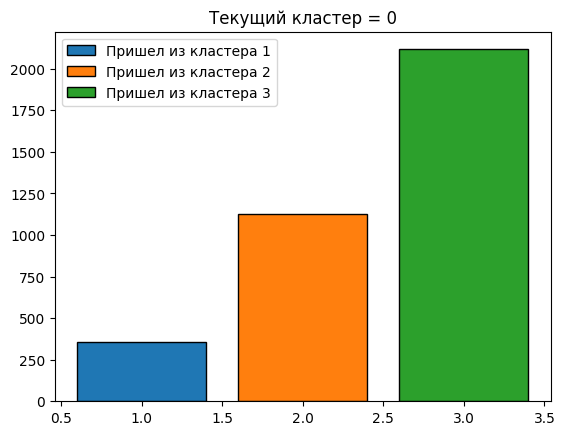

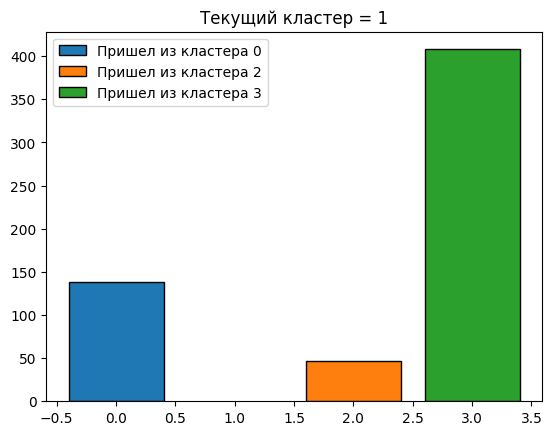

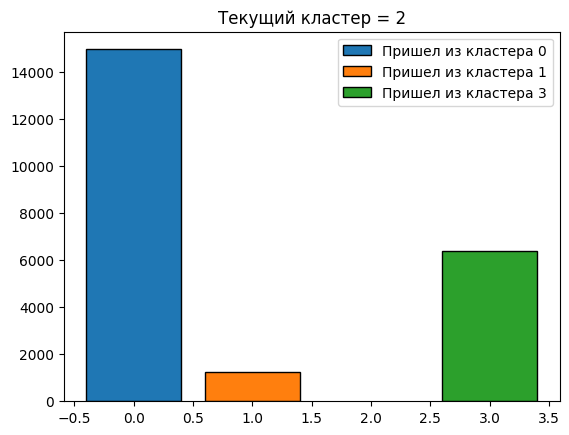

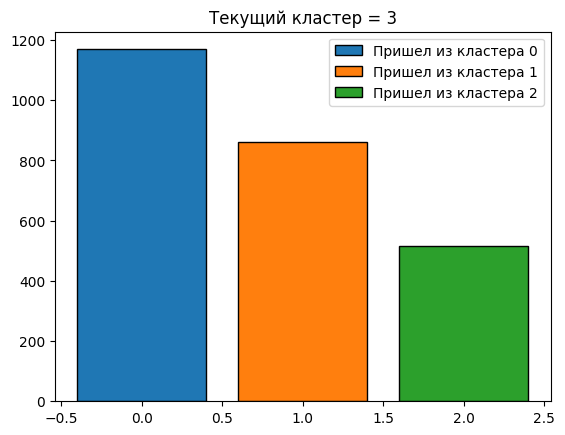

In [ ]:
# Определение клиентов, которые сменили кластер при переходе с предпоследнего периода на последний
for key in movements.keys():
    for new_key in movements[key]:
        if new_key!=key:
            plt.bar(x=new_key, height=len(movements[key][new_key]), label=f'Пришел из кластера {new_key}', ec='black')
        plt.title(f'Текущий кластер = {key}')
        plt.legend()
        plt.show()

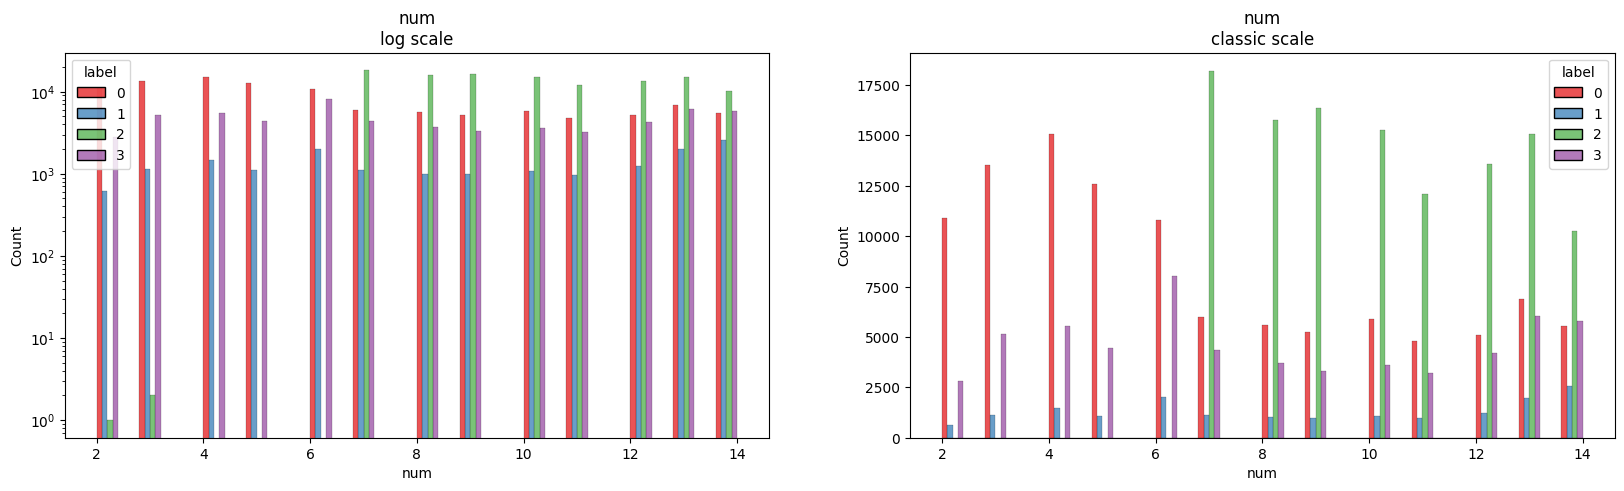

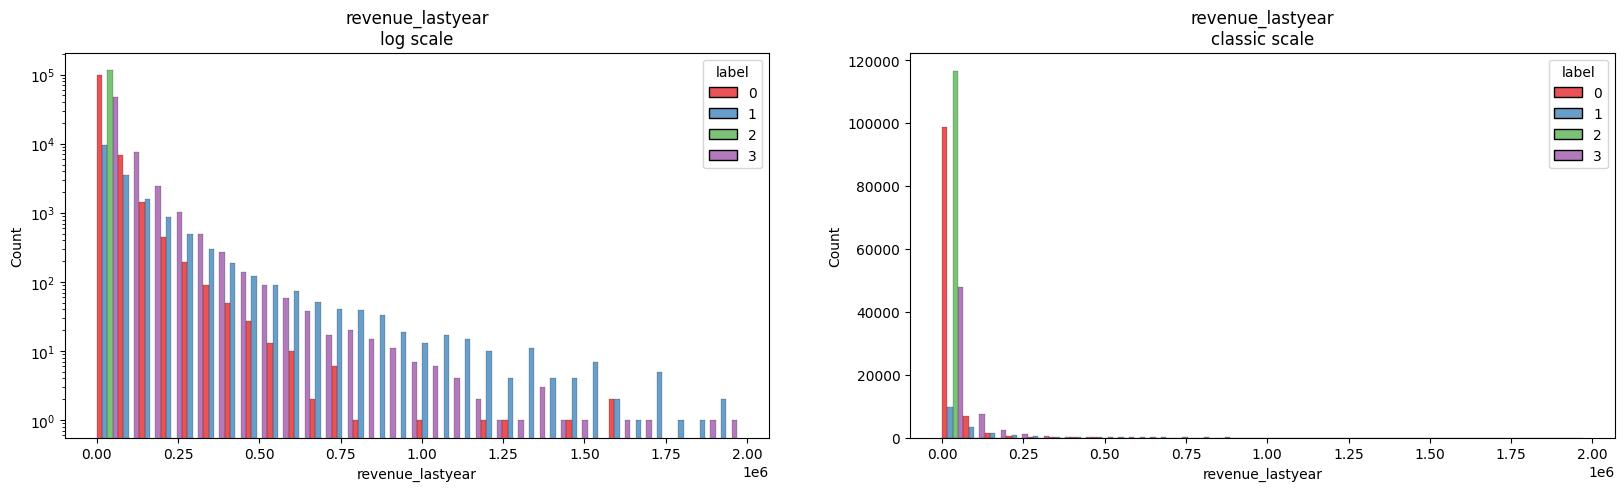

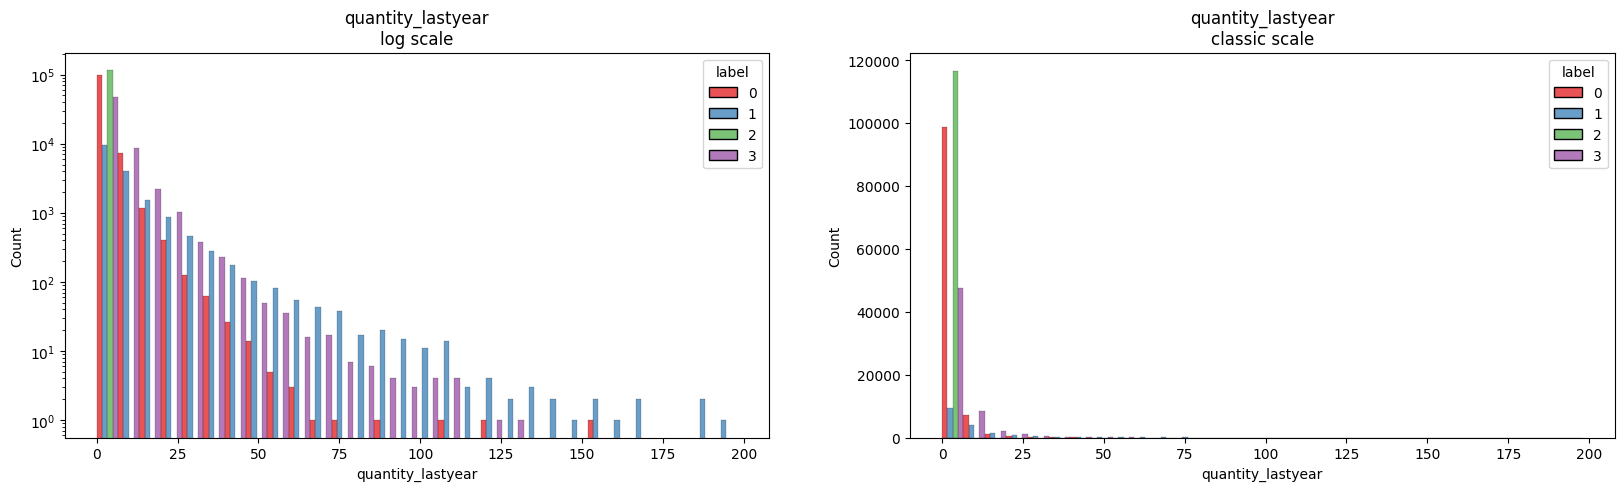

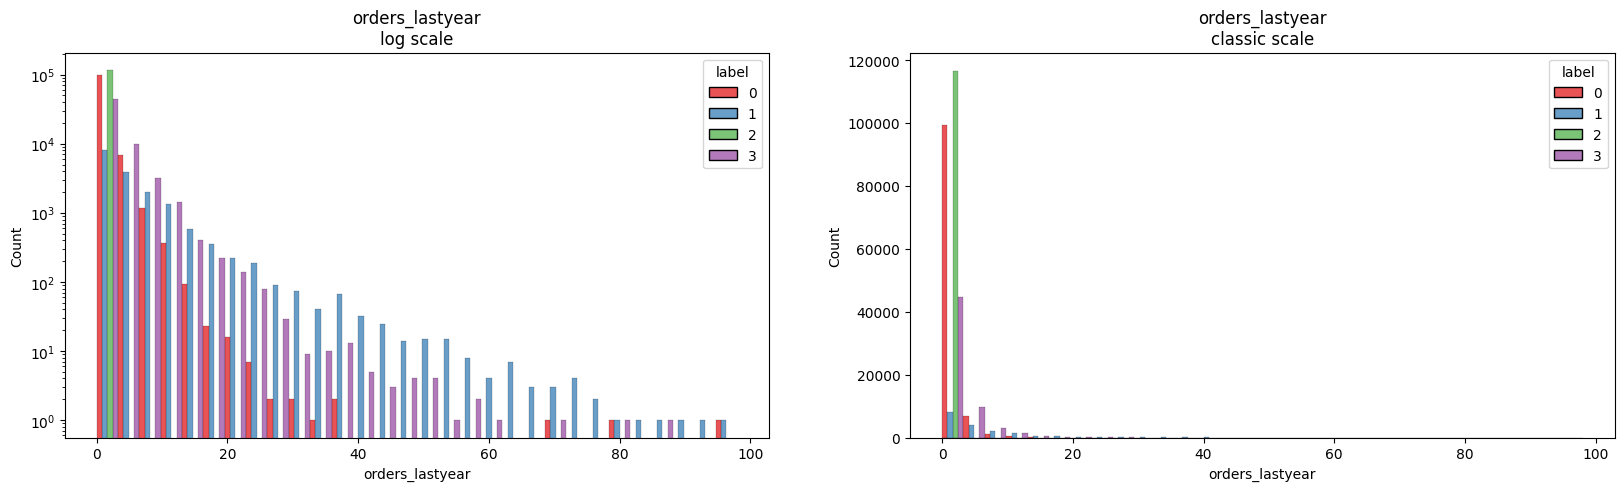

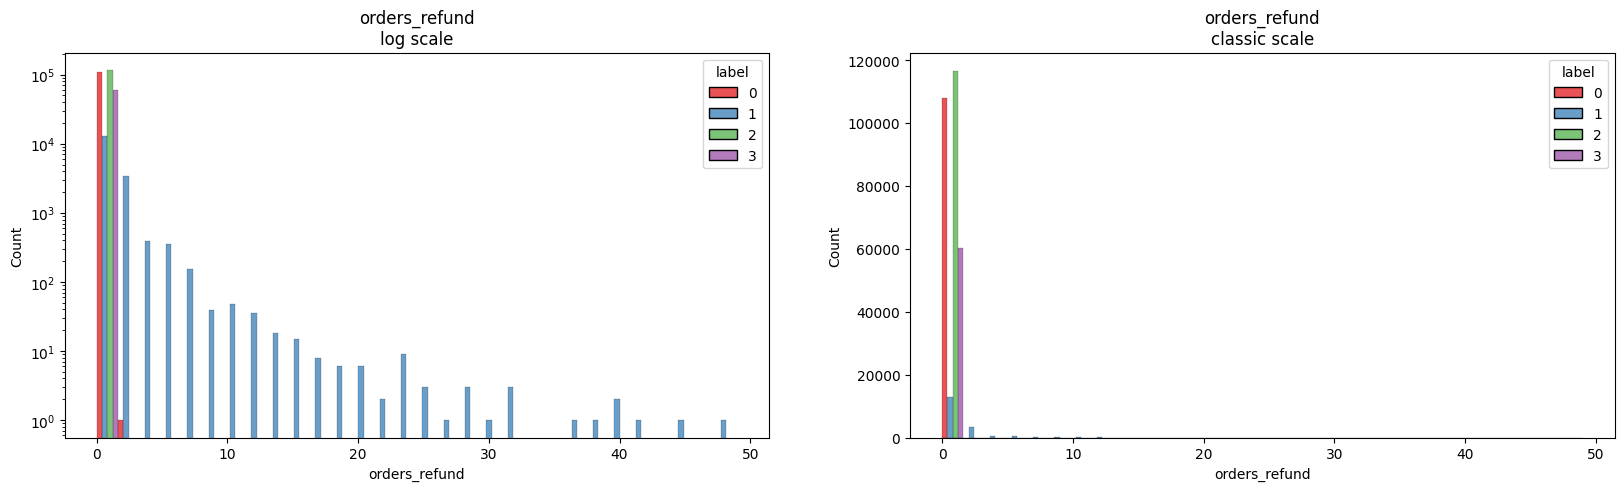

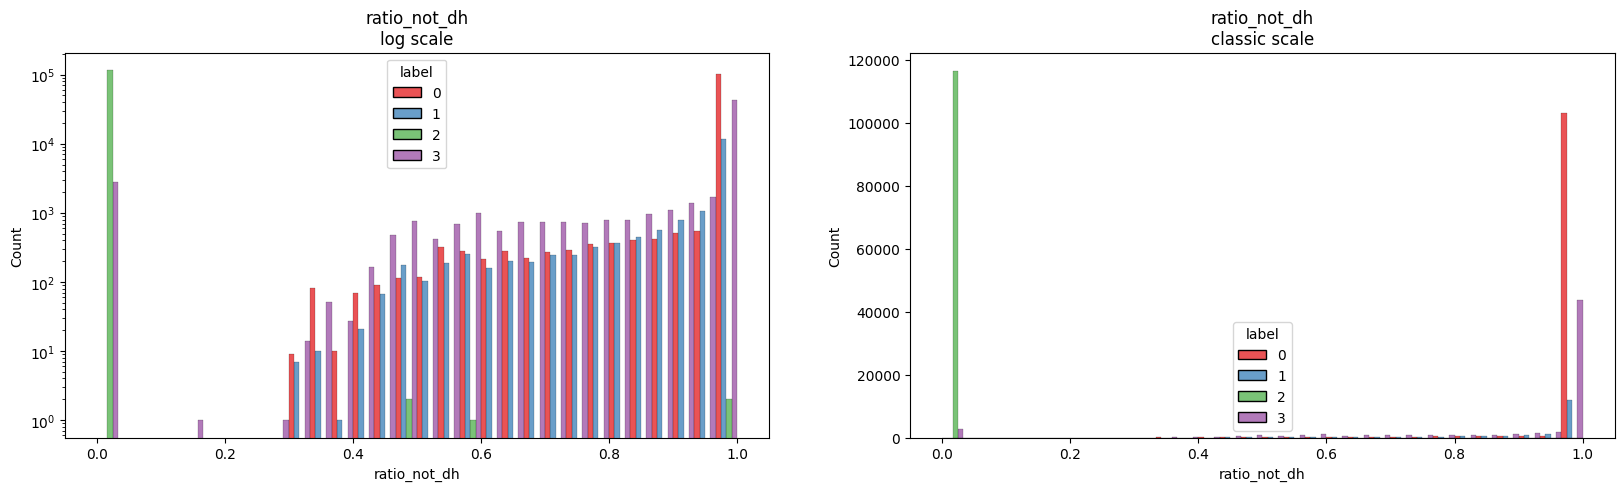

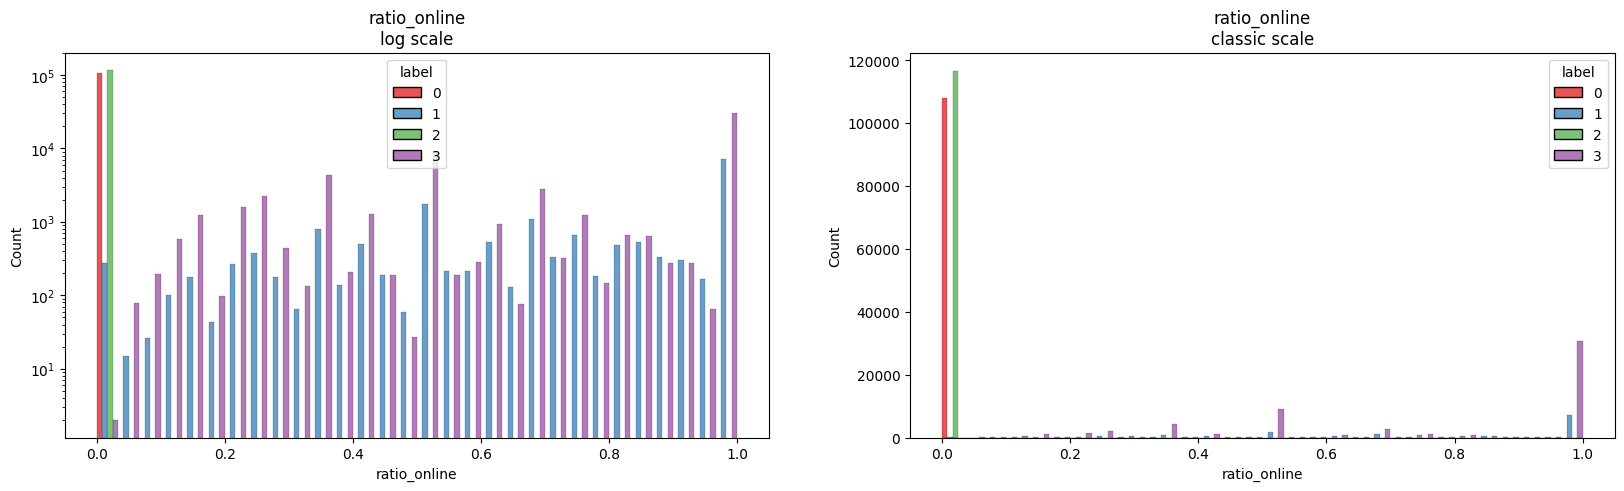

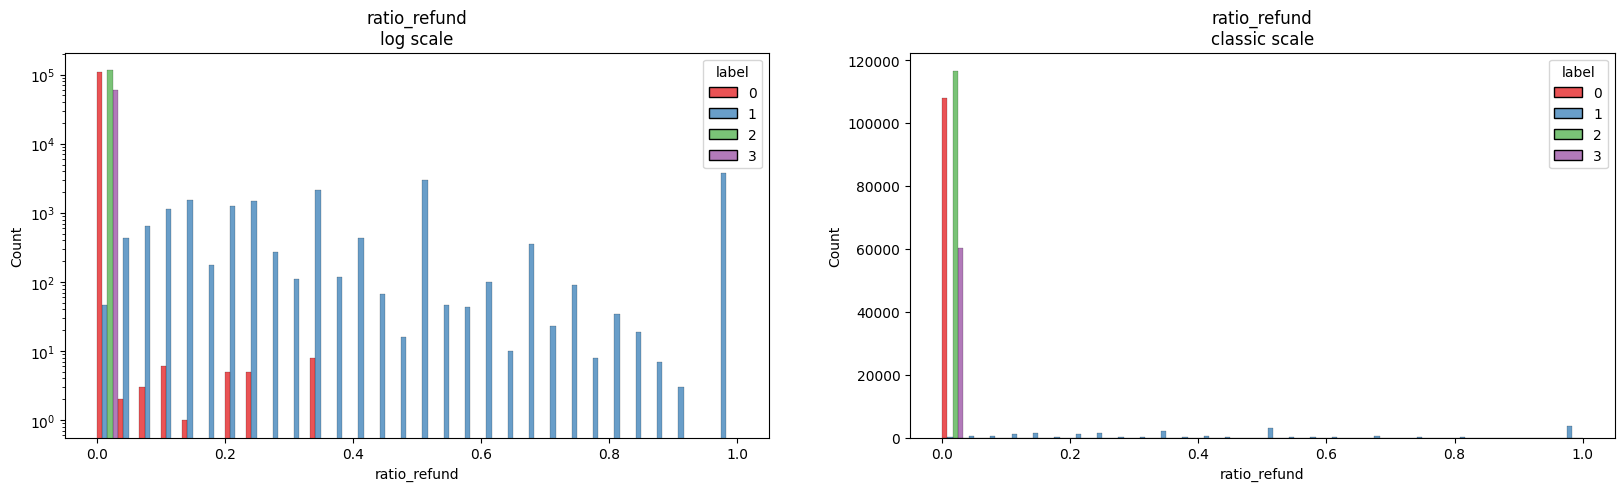

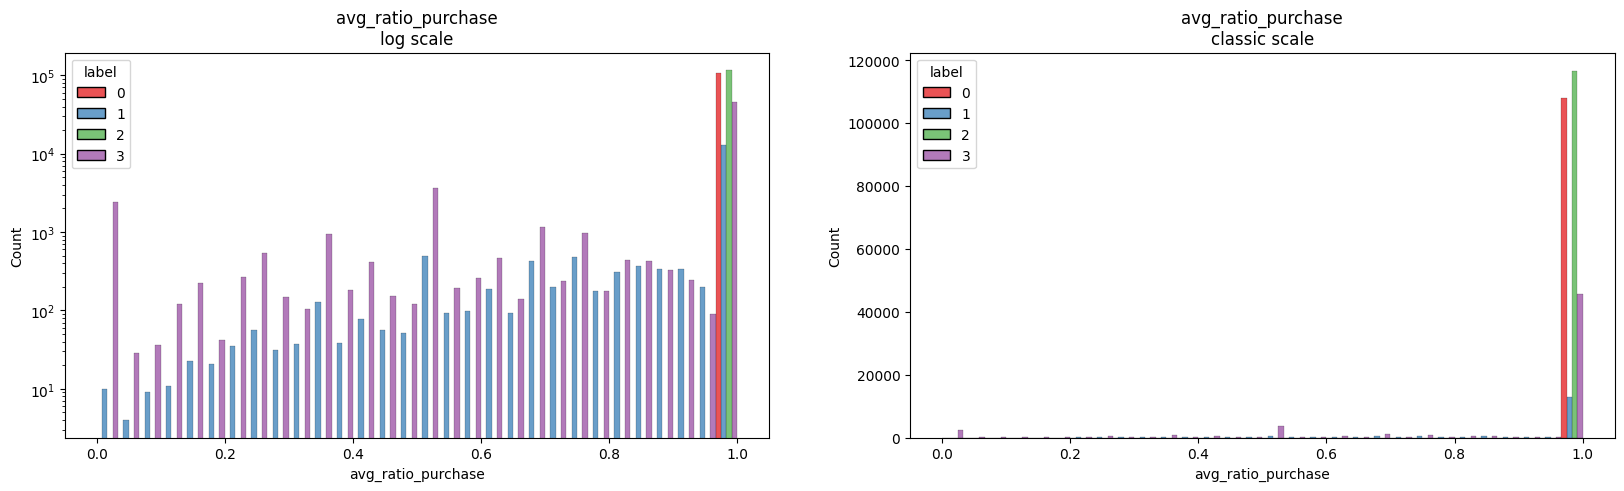

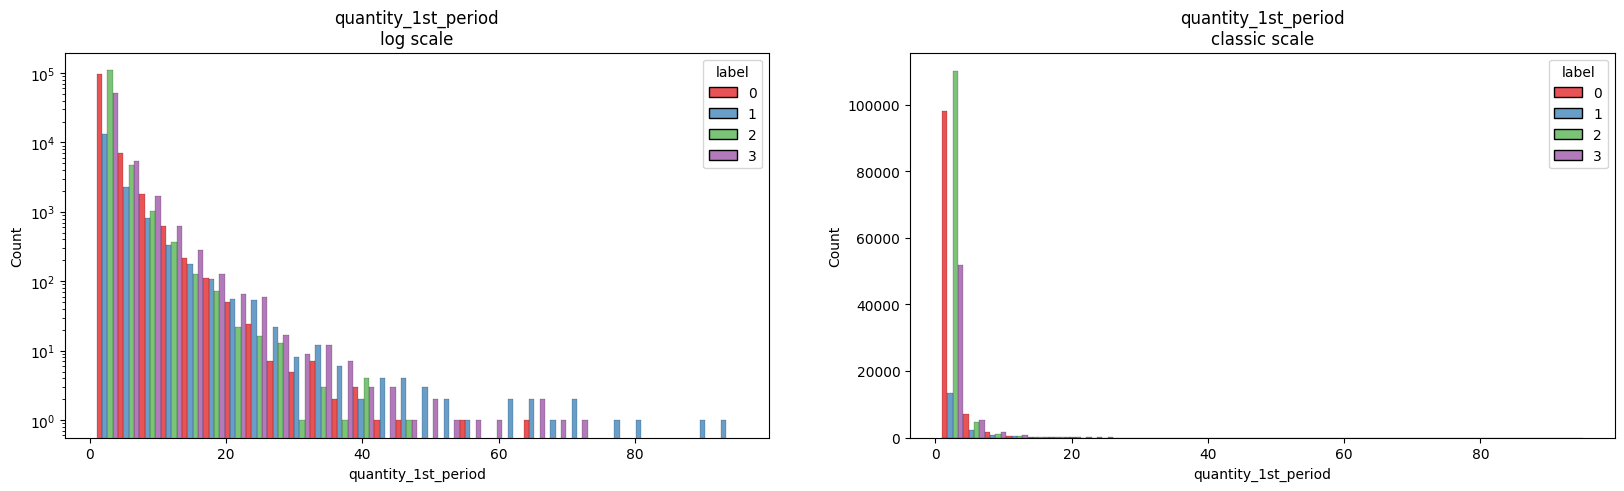

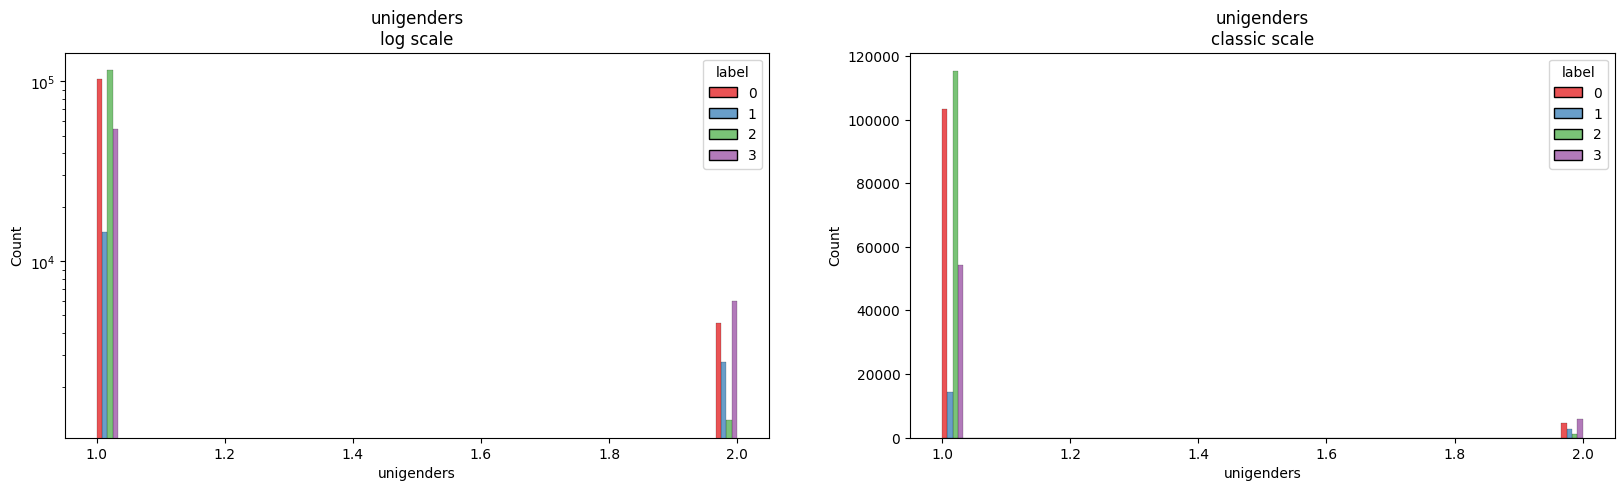

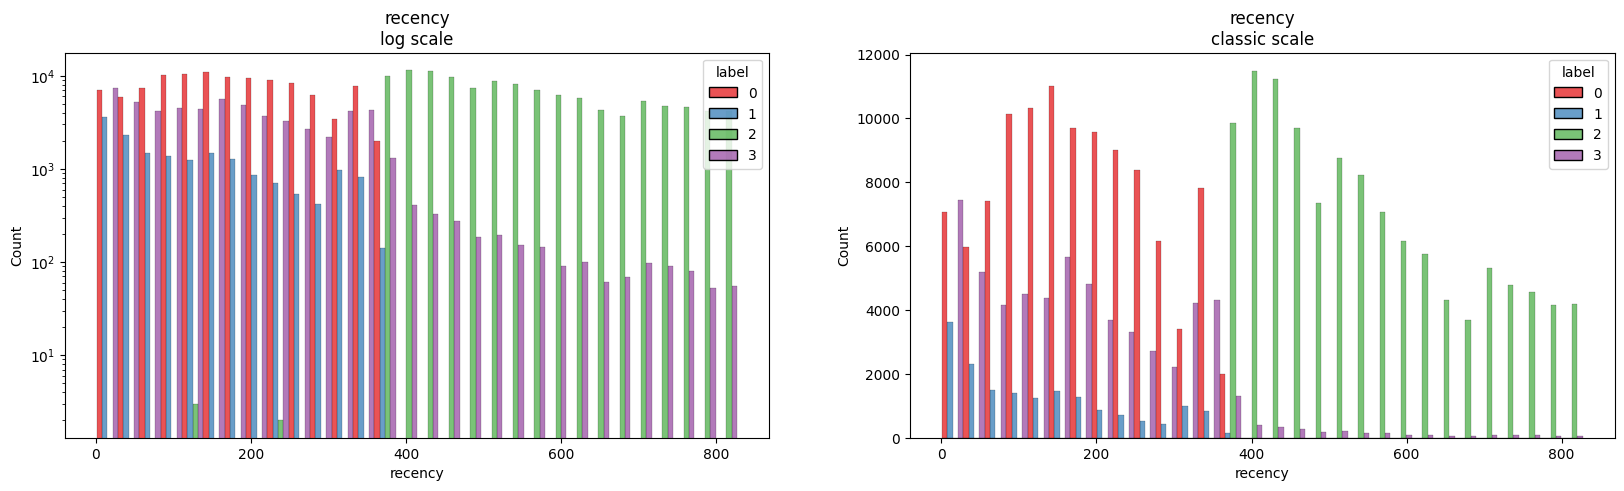

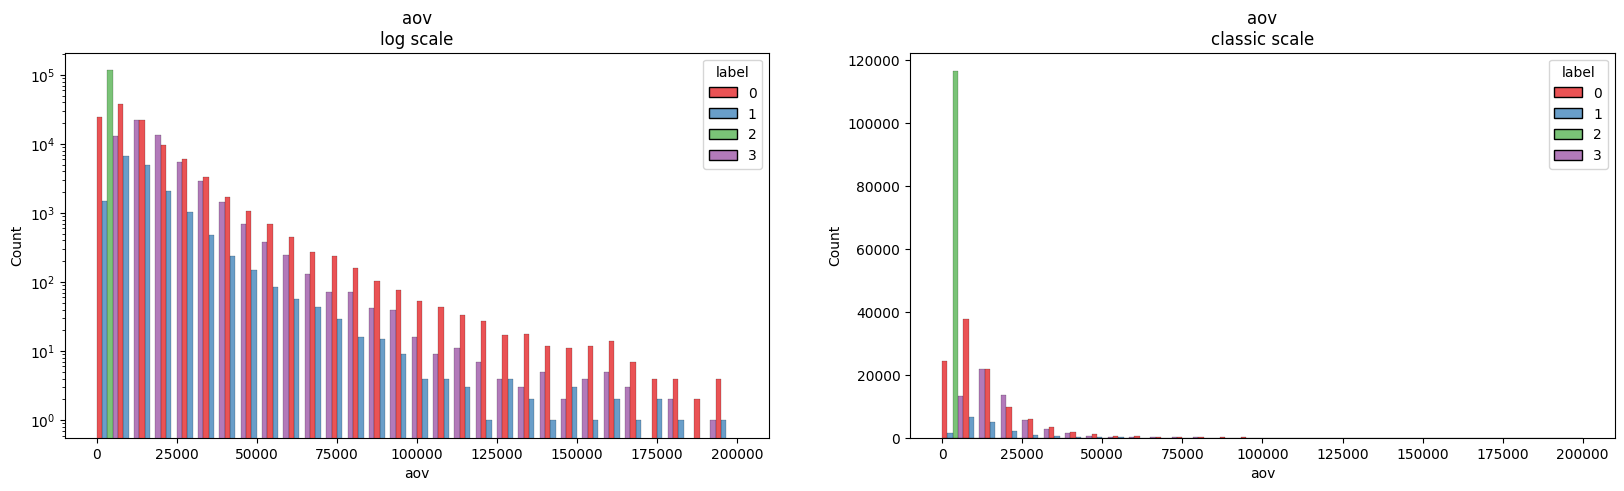

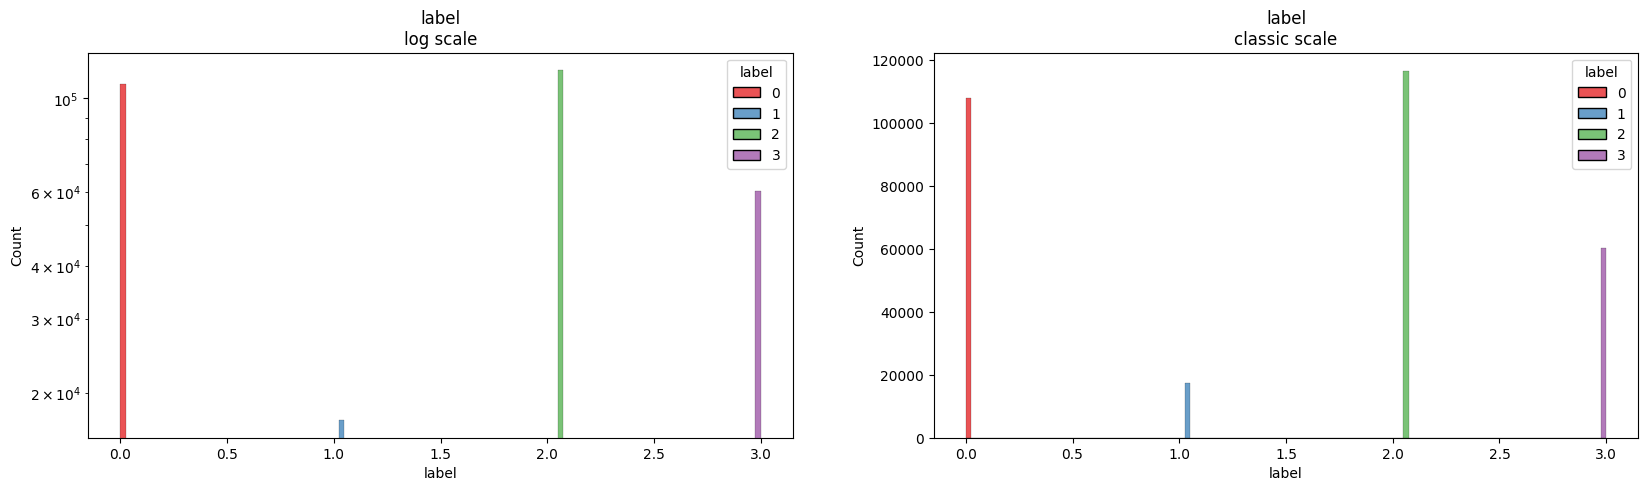

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_functio

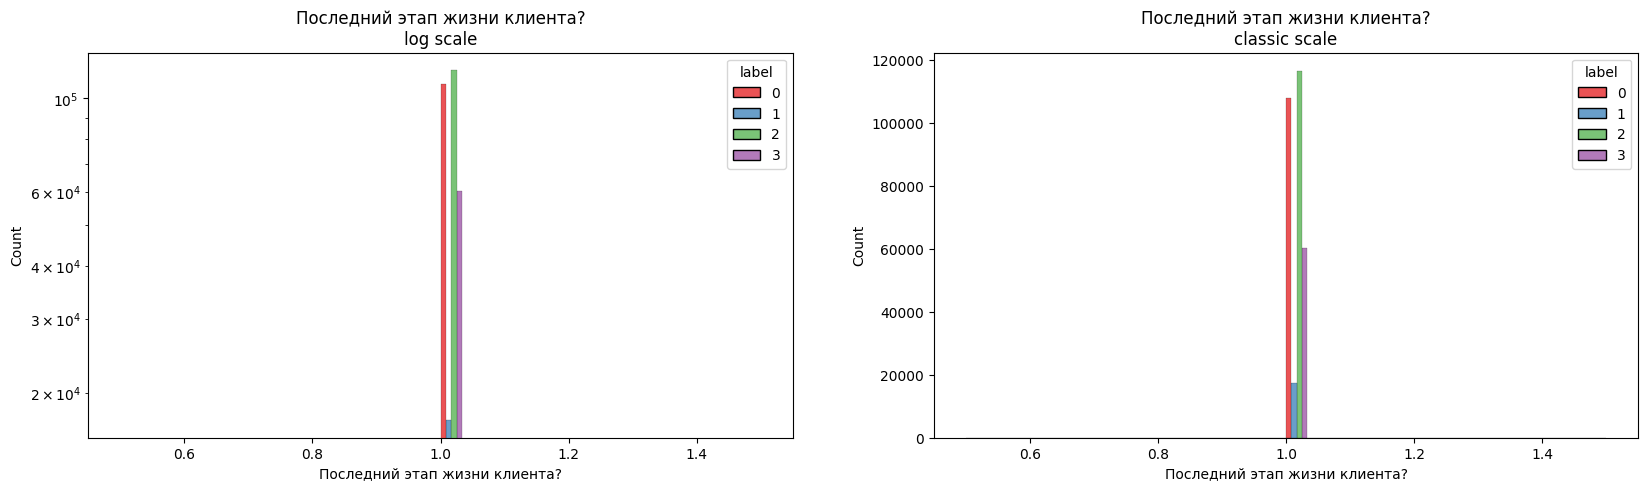

In [ ]:
# Определяем особенности активных клиентов
temp = df_for_check[df_for_check['Последний этап жизни клиента?'] ==True]
for column in temp.columns:
    if column in ['actual_id', 'period_end']:
        continue
    fig, axes = plt.subplots(ncols=2)
    ax1, ax2 = axes.flatten()
    sns.histplot(data=temp,x=column, bins=30, ec='black', hue='label', palette='Set1', multiple="dodge", ax=ax1)
    sns.histplot(data=temp,x=column, bins=30, ec='black', hue='label', palette='Set1', multiple="dodge", ax=ax2)
    ax1.set_yscale('log')
    ax1.set_title(f'{column}\nlog scale')
    ax2.set_title(f'{column}\nclassic scale')
    plt.gcf().set_size_inches(20, 5)
    plt.show()

##### 8. Дальнейшая оценка и описание сформированных кластеров доступно в приложенном Excel-файле